# Load Library

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random
import statistics
import math
from collections import Counter
import scipy.stats as stats
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import urllib
#import dataframe_image as dfi

%matplotlib inline

pd.set_option('display.max_columns', None)

# Load Data

In [3]:
# From Google Drive
file_path_patient = "covid_pts_enc_level_labs_dx_2021-02-02_deid.csv"
file_path_patient_extra = "meds_admin_for_SOFA_COVID_cohort_SDH_share.csv"
file_path_zip_tx = 'zip_code_data.csv'
file_path_census_tract = 'zcta_tract_rel_10.csv'
file_path_svi_tx = 'Texas.csv'

# Read csv as a dataframe from the path
df = pd.read_csv(file_path_patient, index_col=False)
df_extra = pd.read_csv(file_path_patient_extra, index_col=False)
df_zip_tx = pd.read_csv(file_path_zip_tx, index_col=False)
df_census_tract = pd.read_csv(file_path_census_tract, index_col=False)
df_svi_tx = pd.read_csv(file_path_svi_tx)

# Define Functions

In [4]:
# https://www.mdcalc.com/sequential-organ-failure-assessment-sofa-score
# https://www.mdcalc.com/sequential-organ-failure-assessment-sofa-score#evidence
# https://ccforum.biomedcentral.com/articles/10.1186/s13054-019-2663-7

calibration_mortality_sofa = {
    0: 0.0,
    1: 0.0,
    2: 6.4,
    3: 6.4,
    4: 20.2,
    5: 20.2,
    6: 21.5,
    7: 21.5,
    8: 33.3,
    9: 33.3,
    10: 50.0,
    11: 50.0,
    12: 95.2,
    13: 95.2,
    14: 95.2,
    15: 95.2,
    16: 95.2,
    17: 95.2,
    18: 95.2,
    19: 95.2,
    20: 95.2,
    21: 95.2,
    22: 95.2,
    23: 95.2,
    24: 95.2
}

def calculate_sofa(patient):  # Calculate SOFA scores
    score = 0
    
    # 1. Respiratory system: PaO2/FiO2 (mmHg)
    if (patient['pO2_Art']/patient['FiO2/Percent'])*100 >= 300 and (patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 399:
        score += 1 
        
    elif ((patient['pO2_Art']/patient['FiO2/Percent'])*100 >= 200 and (patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 299) or ((patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 199 and patient['vent_hours_summed'] == np.nan):
        score += 2
        
    elif (patient['pO2_Art']/patient['FiO2/Percent'])*100 >= 100 and (patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 199 and patient['vent_hours_summed'] != np.nan:
        score += 3
        
    elif (patient['pO2_Art']/patient['FiO2/Percent'])*100 < 100 and patient['vent_hours_summed'] != np.nan:
        score += 4
        
    # 2. Nervous system: Glasgow Coma Scale
    if patient['Glasgow_Coma_Score'] == 13 or patient['Glasgow_Coma_Score'] == 14:
        score += 1 
        
    elif patient['Glasgow_Coma_Score'] >= 10 and patient['Glasgow_Coma_Score'] <= 12:
        score += 2
        
    elif patient['Glasgow_Coma_Score'] >= 6 and patient['Glasgow_Coma_Score'] <= 9:
        score += 3
        
    elif patient['Glasgow_Coma_Score'] < 6:
        score += 4
    
    # 3. Cardiovascular system: Mean arterial pressure (MAP) OR administration of vasopressors required
    if patient['Mean_Arterial_Pressure'] < 70:
        score += 1 
    
    elif (patient['medication_name']=='dopamine' and patient['dose_of_medication'] <= 5) or (patient['medication_name']=='dobuTamine' and patient['dose_of_medication'] !=np.nan):
        score += 2

    elif (patient['medication_name']=='dopamine' and patient['dose_of_medication'] > 5 and patient['medication_name']=='epinephrine' and patient['dose_of_medication'] <= 0.1)or (patient['medication_name']=='norepinephrine' and patient['dose_of_medication'] <= 0.1):
        score += 3
   
    elif (patient['medication_name']=='dopamine' and patient['dose_of_medication'] > 15 and patient['medication_name']=='epinephrine' and patient['dose_of_medication'] > 0.1) or (patient['medication_name']=='norepinephrine' and patient['dose_of_medication'] > 0.1):
        score += 4

    # 4. Liver: Bilirubin (mg/dl) [μmol/L] 
    if float(patient['Bili_Total']) >= 1.2 and float(patient['Bili_Total']) <= 1.9:
        score += 1 
        
    elif float(patient['Bili_Total']) >= 2.0 and float(patient['Bili_Total']) <= 5.9:
        score += 2
        
    elif float(patient['Bili_Total']) >= 6.0 and float(patient['Bili_Total']) <= 11.9:
        score += 3
        
    elif float(patient['Bili_Total']) >= 12.0:
        score += 4

    # 5. Coagulation: Platelets ×103/ml
    if patient['Platelet'] >= 100 and patient['Platelet'] < 150:
        score += 1 
        
    elif patient['Platelet'] >= 50 and patient['Platelet'] < 100:
        score += 2
        
    elif patient['Platelet'] >= 20 and patient['Platelet'] < 50:
        score += 3
        
    elif patient['Platelet'] < 20:
        score += 4
        
    # 6. Kidneys: Creatinine (mg/dl) [μmol/L]; urine output
    if patient['Creatinine'] >= 1.2 and patient['Creatinine'] <= 1.9:
        score += 1 
        
    elif patient['Creatinine'] >= 2.0 and patient['Creatinine'] <= 3.4:
        score += 2
        
    elif patient['Creatinine'] >= 3.5 and patient['Creatinine'] <= 4.9:
        score += 3
        
    elif patient['Creatinine'] >= 5.0:
        score += 4 
    
    return score

def count_comorbidity(patient): # Calculate comorbidity conditions
    count = 0 
    
    if patient.COPD_com_flag == 1:
        count += 1 
        
    if patient.asthma_com_flag == 1:
        count += 1 
        
    if patient.diabetes_com_flag == 1:
        count += 1 
        
    if patient.hypertension_com_flag == 1:
        count += 1 
        
    if patient.CAD_com_flag == 1:
        count += 1 
        
    if patient.heartfailure_com_flag == 1: 
        count += 1 
        
    if patient.CKD_com_flag == 1:
        count += 1 
        
    if patient.cancer_com_flag == 1:
        count += 1 
        
    return count

def percentage_death(race):       # Calculate percentage of deaths for each race
    count = count_race[race['race']] # Number of patients in their racial groups

    return (race.count_death / count) * 100

ls_race = ['White', 'Black or African American', 'Hispanic or Latino', 'Asian']
def latinx(patient):  # Clean up race
    if patient['ethnicity_display'] == 'Hispanic or Latino' and patient['race_display'] == 'White':
        return "Hispanic or Latino"
    elif patient['ethnicity_display'] == 'Not Hispanic or Latino' and patient['race_display'] == 'White': 
        return "White"
    elif patient['race_display'] == 'Hispanic':
        return "Hispanic or Latino"
    else:
        return patient['race_display']

def visualize_count_mortality(df, strategy):
    df['aval'] = df['aval'].replace(to_replace=[2.0], value=['Observed'])
    ax_x = list(df['aval'].unique())
    ax_x.append(ax_x.pop(0))
    sns_plot = sns.catplot(x='aval', y='count_death', hue='race', data=df, kind='bar', height=4, aspect=3, order=ax_x)
    plt.title('Allocation Strategy ({})'.format(strategy))
    plt.xlabel('Ventilator Availability(%)')
    plt.ylabel('Mortality Count')
    plt.show()
    sns_plot._legend.set_title('Race')
    sns_plot.savefig("figure/race/count_death_{}.png".format(strategy))

def visualize_percentage_mortality(df, strategy):
    df['aval'] = df['aval'].replace(to_replace=[2.0], value=['Observed'])
    ax_x = list(df['aval'].unique())
    ax_x.append(ax_x.pop(0))
    sns_plot = sns.catplot(x='aval', y='percentage_death', hue='race', data=df, kind='bar', order=ax_x, height=4, aspect=3)
    plt.title('Allocation Strategy ({})'.format(strategy))
    plt.xlabel('Ventilator Availability(%)')
    plt.ylabel('Mortality Rate')
    plt.show()
    sns_plot._legend.set_title('Race')
    sns_plot.savefig("figure/race/percentage_death_{}.png".format(strategy))

# Preprocess Data

## Data: Extra

In [5]:
# Extract only rows containing 'mcg/kg/min'.
# Remove 'mcg/kg/min' from string and convert the numeric values into float.
df_extra = df_extra.loc[df_extra['dose_of_medication'].str.contains('mcg/kg/min')].copy()
df_extra['dose_of_medication'] =  df_extra.loc[:, 'dose_of_medication'].apply(lambda x: re.sub('mcg/kg/min', '0', x)).copy()
df_extra['dose_of_medication'] = df_extra.loc[:, 'dose_of_medication'].apply(lambda x: re.sub('\ .*','', x)).copy()
df_extra['dose_of_medication'] = df_extra['dose_of_medication'].astype(float)

# There are encounters that have multiple 'dose_of_medication' for each encounter
# Extract only rows including the maximum values in 'dose_of_medication' for each encounter.
df_extra = df_extra.groupby(['medication_name', 'deid_fin_encounter']).max().reset_index()

print(df_extra.shape)
df_extra.head()

(147, 5)


,medication_name,deid_fin_encounter,dose_of_medication,administration_dt_tm,SOFA
0,dobuTamine,25093,2.50,2020-10-26T13:00:00.000-05:00,NaN
1,dobuTamine,30090,5.00,2020-09-10T12:40:00.000-05:00,NaN
2,dobuTamine,36262,5.00,2020-10-21T15:00:00.000-05:00,NaN
3,dobuTamine,44845,0.75,2020-11-13T00:19:00.000-06:00,NaN
4,dopamine,32723,0.00,2020-11-05T11:56:00.000-06:00,NaN


## Data: Zip Code

In [6]:
# Delete columns: male_poverty_rate, female_poverty_rate, mean_income
df_zip_tx =  df_zip_tx.loc[:, ['zip_code', 'median_income', 'poverty_rate']]
print(df_zip_tx.shape)
df_zip_tx.head()

(1935, 3)


,zip_code,median_income,poverty_rate
0,ZCTA5 75001,72512,10.9
1,ZCTA5 75002,101429,4.9
2,ZCTA5 75006,64462,10.8
3,ZCTA5 75007,86648,6.7
4,ZCTA5 75009,111146,4


In [7]:
df_zip_tx['zip_code'] = df_zip_tx['zip_code'].apply(lambda row: row.strip('ZCTA5 '))

ls_zip_error = []   
for code in df_zip_tx['zip_code']: # There zip codes that are not 5-digit number
    if len(code) != 5:
        ls_zip_error.append(code)

print("All zip codes: {}".format(len(df_zip_tx)))
print("Normal zip codes (5-digit): {}".format(len(df_zip_tx)-len(ls_zip_error)))
print('Abnormal zip codes (Non 5-digit): {}'.format(len(ls_zip_error)))

All zip codes: 1935
Normal zip codes (5-digit): 1744
Abnormal zip codes (Non 5-digit): 191


In [8]:
# https://www.zipcodestogo.com/Texas/
# https://worldpopulationreview.com/zips/texas

# Erroneous zip codes are cut off if there are single or continuous 5
for zip_error in ls_zip_error:  # Attach 5s as last digits to erroneous zip codes
    if len(zip_error) == 4:
        df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"] = df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"].values[0] + str(5)
    elif len(zip_error) == 3:
        df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"] = df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"].values[0] + str(55)
    elif len(zip_error) == 1:
        df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"] = df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"].values[0] + str(5555)

df_zip_tx["zip_code"] = df_zip_tx["zip_code"].astype(int)

## Data: Census Tract

In [9]:
# https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/2010-census-tract-record-layout.html

# Extract only data from Texas state(=48)
df_census_tract_tx = df_census_tract.loc[df_census_tract['STATE']==48].copy()
df_census_tract_tx.reset_index(drop=True, inplace=True)

print(df_census_tract_tx.shape)
df_census_tract_tx.head()

# Extract only data from Texas state Travis county
# df_census_tract_tx_travis = df_census_tract.loc[(df_census_tract['STATE']==48) & (df_census_tract['COUNTY']==453)].copy()

(10009, 25)


,ZCTA5,STATE,COUNTY,TRACT,GEOID,POPPT,HUPT,AREAPT,AREALANDPT,ZPOP,ZHU,ZAREA,ZAREALAND,TRPOP,TRHU,TRAREA,TRAREALAND,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT,TRPOPPCT,TRHUPCT,TRAREAPCT,TRAREALANDPCT
0,73949,48,421,950200,48421950200,410,190,287805986,287805986,1688,764,1366353259,1360361346,3034,1252,2391079318,2390650564,24.29,24.87,21.06,21.16,13.51,15.18,12.04,12.04
1,75001,48,113,13616,48113013616,4152,3223,2014512,2014512,12414,8102,9940470,9931768,5611,4018,3630263,3630263,33.45,39.78,20.27,20.28,74.00,80.21,55.49,55.49
2,75001,48,113,13725,48113013725,0,0,247511,247511,12414,8102,9940470,9931768,3615,1909,1839456,1839456,0.00,0.00,2.49,2.49,0.00,0.00,13.46,13.46
3,75001,48,113,13726,48113013726,2673,1488,1593774,1585072,12414,8102,9940470,9931768,2673,1488,1593774,1585072,21.53,18.37,16.03,15.96,100.00,100.00,100.00,100.00
4,75001,48,113,13727,48113013727,3231,1983,4937525,4937525,12414,8102,9940470,9931768,3235,1984,5171932,5171932,26.03,24.48,49.67,49.71,99.88,99.95,95.47,95.47


In [10]:
# Remove zip codes not associated with Texas
ls_idx = df_census_tract_tx.index
ls_idx_drop = []

for code in [73949, 88063, 88220, 88430]:
    idx = ls_idx[df_census_tract_tx["ZCTA5"]==code]
    ls_idx_drop.append(idx.to_list()[0])

df_census_tract_tx.drop(ls_idx_drop, inplace=True)

## Data: SVI

It seems that different zip codes indicate one single GEOID(Census Tract). In other words, the census tract number can indicate multiple zip codes.

In [11]:
# https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI_documentation_2018.html

# Use only columns for socioeconomic status: 'FIPS', 'E_TOTPOP', 'E_POV', 'E_UNEMP', 'E_PCI', 'E_NOHSDP'
df_svi_tx = df_svi_tx[[
    'FIPS', 'E_TOTPOP', 'E_POV', 'EP_POV', 'E_UNEMP', 'EP_UNEMP', 'E_PCI', 'E_NOHSDP', 'EP_NOHSDP',
    'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES',
    'F_THEME1', 'F_THEME2', 'F_THEME3', 'F_THEME4', 'F_TOTAL']]

print(df_svi_tx.shape)
df_svi_tx.head()

(5254, 19)


,FIPS,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL
0,48001950100,5164,827,16.2,65,3.1,26849,386,10.9,0.3853,0.7610,0.1308,0.7545,0.4965,0,0,0,1,1
1,48001950401,4872,3,1.0,0,0.0,2520,1061,25.4,0.4162,0.0230,0.3439,0.5421,0.2477,1,0,0,1,2
2,48001950402,7548,44,20.3,4,2.2,1329,2190,30.3,0.6895,0.0626,0.3219,0.3123,0.3422,1,1,0,1,3
3,48001950500,4569,946,21.1,110,5.3,15961,577,19.5,0.7202,0.7878,0.6467,0.9167,0.8433,0,0,0,0,0
4,48001950600,5570,549,10.0,99,3.8,19854,1053,28.6,0.5552,0.4861,0.2766,0.7387,0.5470,0,0,0,0,0


In [12]:
# Replace SVI scores that are -999(NULL) with numpy nan value
df_svi_tx.loc[df_svi_tx["RPL_THEMES"] < 0, "RPL_THEMES"] = np.nan

## Data: Sample(df_icu)

In [13]:
# Patients who were admitted to ICU, had SOFA scores, and were in one of racial groups (White, Black or African American, Hispanic or Latino, Asian)
df_icu = df.loc[df['icu_hours_summed'].notnull()]

print(df_icu.shape)
df_icu.head()

(741, 70)


,admit_dt_tm,discharge_dt_tm,facility,encounter_type_display,age_at_admit,gender,zip_cust_table,ethnicity_display,race_display,race_eth_comb,length_of_stay,icd_prim,deceased_dt_tm,discharge_disposition_display,dc_dispo_cat,insured_uninsured,admit_source,arrival_mode,vent_hours_summed,vent_first_order_start_time,vent_last_order_end_time,icu_hours_summed,icu_first_begin_time,icu_last_end_time,occupation,occ_cat,emp_yn,Creatinine,Abs_Lymph,ALT,AST,Bili_Total,D-Dimer,Diastolic_Blood_Pressure,Dosing_Weight_(kg),FiO2/Percent,Glasgow_Coma_Score,Lymph_Auto,Oxygen_Delivery_Method,Oxygen_Saturation,Platelet,pO2_Art,Procalcitonin,Respiratory_Rate,Systolic_Blood_Pressure,Troponin-I,WBC,Oxygen_Flow_Rate,Patient_Smoking_Status,Visit_Reason,Height_(in),Mean_Arterial_Pressure,SARSCOV2,SARSCOV2_Source,heart_pulse_comb,temp_oral_degC,calc_pulled_BMI,no_dx_data,COPD_com_flag,asthma_com_flag,diabetes_com_flag,hypertension_com_flag,CAD_com_flag,heartfailure_com_flag,CKD_com_flag,cancer_com_flag,qSOFA_score,deid_empi_encounter,deid_mrn_encounter,deid_fin_encounter
0,2020-08-25 20:51:00,2020-09-01 14:30:00,Shoal Creek,IP Private/Semi Private room,49,Male,Unknown,Hispanic or Latino,White,White Hispanic,6.75,NaN,NaN,Home,Home,Unknown,Transfer from a Hospital,NaN,NaN,NaN,NaN,36.55,2020-08-25 20:53:00,2020-08-27 09:26:00,NaN,Not yet chart searched,NaN,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,4dMaH,61003,10650
1,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,White,White Hispanic,2.75,A41.9,3/26/2020 14:10,Expired,Expired,Insured,Transfer from a Hospital,NaN,58.45,2020-03-24 05:55:00,2020-03-26 16:22:00,69.48,2020-03-23 21:01:00,2020-03-26 18:30:00,NaN,Not yet chart searched,NaN,2.9,2.0,94,253.0,3.1,>5250,21.0,99.200,50.0,3.0,5.7,Ventilator,96.0,42.0,470.8,24.53,23.0,36.0,0.73,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,30.620000,False,False,False,False,False,False,False,False,False,3.0,8wQnr,84969,27818
6,2020-03-26 15:21:00,2020-04-08 13:15:00,Medical Center,IP Private/Semi Private room,49,Female,78612,Not Hispanic or Latino,White,White Non Hispanic,12.92,U07.1,NaN,Home,Home,Insured,Emergency room,Private Vehicle,293.02,2020-03-28 11:14:00,2020-04-03 14:31:00,160.17,2020-03-30 20:19:00,2020-04-06 12:29:00,TxDOT,Municipal worker,Employed,0.9,0.8,43,48.0,0.5,599,79.0,123.200,100.0,15.0,6.9,Nasal cannula,94.0,355.0,250.1,0.85,28.0,115.0,0.02,12.1,4.0,NaN,SOB,67.0,91.0,NaN,NaN,99.0,37.4,44.890000,False,False,False,False,False,False,False,False,False,1.0,P9yRo,80030,23744
11,2020-03-28 18:59:00,2020-06-01 15:15:00,Medical Center,IP ICU,24,Male,78753,Not Hispanic or Latino,White,White Non Hispanic,64.88,U07.1,NaN,Long Term Care Hospital,NaN,Insured,Transfer from a Hospital,NaN,1423.18,2020-03-28 22:09:00,2020-05-27 04:53:00,1559.88,2020-03-28 15:22:00,2020-06-01 15:15:00,Student,Other,Employed,1.5,4.2,69,146.0,0.4,>5250,68.0,116.000,80.0,3.0,10.6,Ventilator,89.0,370.0,56.4,18.92,28.0,102.0,0.07,19.4,50.0,NaN,ECMO,NaN,NaN,Positive,Nasophar. swab,143.0,37.1,34.540000,False,False,False,False,False,False,False,False,False,2.0,23f5M,84794,37705
17,2020-03-31 14:14:00,2020-04-17 17:20:00,Medical Center,IP ICU,55,Male,78602,Not Hispanic or Latino,White,White Non Hispanic,17.13,U07.1,4/17/2020 14:08,Expired,Expired,Insured,Emergency room,Private Vehicle,327.77,2020-04-07 08:40:00,2020-04-17 15:56:00,336.42,2020-04-03 16:55:00,2020-04-17 17:20:00,Business - Drilling,Business,Employed,1.2,1.0,20,36.0,0.6,224,76.0,90.718,100.0,15.0,11.7,Room air,93.0,199.0,102.6,1.61,20.0,122.0,NaN,4.6,2.0,Never smoker,SOB,71.0,91.3,NaN,NaN,80.0,38.9,27.893795,False,False,True,False,True,False,False,False,False,0.0,mNyVy,84725,15345


In [14]:
# Make a distinction between White and Hispanic/Latino
df_icu.loc[:, ['race_display']] = df_icu.loc[:, ['race_display', 'ethnicity_display']].apply(lambda patient: latinx(patient), axis=1)
df_icu = df_icu.loc[df_icu['race_display'].isin(ls_race)]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [15]:
# Fill out the missing values in columns related to comorbodity conditions with 0
# Convert True/False value into 1/0
cols_comorbidity = ['COPD_com_flag', 'asthma_com_flag', 'diabetes_com_flag',
                    'hypertension_com_flag', 'CAD_com_flag', 'heartfailure_com_flag',
                    'CKD_com_flag', 'cancer_com_flag']

df_icu[cols_comorbidity] = df_icu[cols_comorbidity].fillna(0)
df_icu[cols_comorbidity] = df_icu[cols_comorbidity].astype(int)

In [16]:
# Generate columns for comorbidity count and flag
df_icu['count_comorbidity'] = df_icu.apply(lambda patient: count_comorbidity(patient), axis=1)
df_icu['has_comorbidity'] = df_icu['count_comorbidity'].apply(lambda count: 1 if count >= 1 else 0)

In [17]:
# Generate column for age
df_icu['life_years'] = df_icu['age_at_admit'].apply(lambda age: 100 - age)

In [18]:
# Filter out patients who do not have specific zip codes or have ones out ot Texas
display(df_icu.loc[(df_icu['zip_cust_table']=='Unknown') | (df_icu['zip_cust_table']=='10029')])
df_icu.drop(df_icu.index[df_icu['zip_cust_table']=='Unknown'], inplace=True)
df_icu.drop(df_icu.index[df_icu['zip_cust_table']=='10029'], inplace=True)
df_icu['zip_cust_table'] = df_icu['zip_cust_table'].astype(int)

,admit_dt_tm,discharge_dt_tm,facility,encounter_type_display,age_at_admit,gender,zip_cust_table,ethnicity_display,race_display,race_eth_comb,length_of_stay,icd_prim,deceased_dt_tm,discharge_disposition_display,dc_dispo_cat,insured_uninsured,admit_source,arrival_mode,vent_hours_summed,vent_first_order_start_time,vent_last_order_end_time,icu_hours_summed,icu_first_begin_time,icu_last_end_time,occupation,occ_cat,emp_yn,Creatinine,Abs_Lymph,ALT,AST,Bili_Total,D-Dimer,Diastolic_Blood_Pressure,Dosing_Weight_(kg),FiO2/Percent,Glasgow_Coma_Score,Lymph_Auto,Oxygen_Delivery_Method,Oxygen_Saturation,Platelet,pO2_Art,Procalcitonin,Respiratory_Rate,Systolic_Blood_Pressure,Troponin-I,WBC,Oxygen_Flow_Rate,Patient_Smoking_Status,Visit_Reason,Height_(in),Mean_Arterial_Pressure,SARSCOV2,SARSCOV2_Source,heart_pulse_comb,temp_oral_degC,calc_pulled_BMI,no_dx_data,COPD_com_flag,asthma_com_flag,diabetes_com_flag,hypertension_com_flag,CAD_com_flag,heartfailure_com_flag,CKD_com_flag,cancer_com_flag,qSOFA_score,deid_empi_encounter,deid_mrn_encounter,deid_fin_encounter,count_comorbidity,has_comorbidity,life_years
0,2020-08-25 20:51:00,2020-09-01 14:30:00,Shoal Creek,IP Private/Semi Private room,49,Male,Unknown,Hispanic or Latino,Hispanic or Latino,White Hispanic,6.75,NaN,NaN,Home,Home,Unknown,Transfer from a Hospital,NaN,NaN,NaN,NaN,36.55,2020-08-25 20:53:00,2020-08-27 09:26:00,NaN,Not yet chart searched,NaN,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,0,0,0,0,0,0,0,NaN,4dMaH,61003,10650,0,0,51
867,2020-11-21 15:03:00,NaN,Medical Center,IP ICU,68,Female,Unknown,Hispanic or Latino,Hispanic or Latino,White Hispanic,NaN,NaN,NaN,Still a patient,Still a patient,Unknown,Emergency Dept,Private Vehicle,NaN,NaN,NaN,33.13,2020-11-21 20:16:00,2020-11-23 05:24:00,NaN,Not yet chart searched,NaN,2.8,2.30,26,37.0,0.9,NaN,44.0,80.500,NaN,15.0,26.7,Room air,92.0,207.0,NaN,NaN,21.0,77.0,0.01,8.6,NaN,NaN,nv,62.0,55.0,Positive,Nasal Swab,81.0,36.2,32.50,False,0,0,0,0,0,0,0,0,1.0,KJhah,85695,47051,0,0,32
1790,2020-08-27 22:44:00,2020-08-30 12:58:00,Dell Seton Med Cntr UT,IP Private Room,77,Male,10029,Not Hispanic or Latino,Black or African American,Other race Non Hispanic,2.58,I16.1,NaN,Skilled Nursing Care,Rehab/SNF,Insured,Transfer from a Hospital,NaN,NaN,NaN,NaN,23.33,2020-08-27 20:50:00,2020-08-28 20:10:00,NaN,Not yet chart searched,NaN,3.5,1.74,14,26.0,0.4,NaN,101.0,67.700,NaN,15.0,44.7,Room air,100.0,206.0,NaN,NaN,19.0,204.0,0.07,3.9,NaN,NaN,NaN,73.0,NaN,NaN,NaN,68.0,37.2,67.70,False,0,0,1,0,0,1,1,0,0.0,lhGr0,66795,25189,3,1,23
2221,2020-11-20 17:10:00,NaN,Dell Seton Med Cntr UT,IP Private Room,81,Male,Unknown,Not Hispanic or Latino,White,White Non Hispanic,NaN,NaN,NaN,Still a patient,Still a patient,Unknown,Emergency Dept,Private Vehicle,NaN,NaN,NaN,53.13,2020-11-20 22:39:00,2020-11-23 03:47:00,NaN,Not yet chart searched,NaN,1.2,1.53,40,102.0,0.5,1325,90.0,89.811,70.0,15.0,26.0,Room air,95.0,158.0,NaN,NaN,26.0,188.0,3.28,5.9,15.0,NaN,WEAKNESS,76.0,122.7,NaN,NaN,90.0,37.7,23.05,False,0,0,0,0,0,0,0,1,1.0,38pPG,70970,31680,1,1,19
2224,2020-11-21 14:10:00,NaN,Dell Seton Med Cntr UT,IP ICU,64,Male,Unknown,Hispanic or Latino,Hispanic or Latino,White Hispanic,NaN,NaN,NaN,NaN,Still a patient,Unknown,Transfer from a Hospital,NaN,NaN,NaN,NaN,1.73,2020-11-21 12:26:00,2020-11-21 14:10:00,NaN,Not yet chart searched,NaN,0.9,0.69,50,67.0,0.4,3449,58.0,55.200,70.0,15.0,5.8,"Nasal cannula, high flow",96.0,253.0,NaN,0.33,30.0,127.0,0.05,4.6,30.0,NaN,NaN,NaN,NaN,NaN,NaN,79.0,36.9,NaN,True,0,0,0,0,0,0,0,0,1.0,PjvWN,66350,46545,0,0,36


## Merge dataframes

### df_icu & df_extra

In [19]:
df_icu = df_icu.merge(df_extra, on='deid_fin_encounter', how='left')

print(df_icu.shape)
df_icu.head()

(712, 77)


,admit_dt_tm,discharge_dt_tm,facility,encounter_type_display,age_at_admit,gender,zip_cust_table,ethnicity_display,race_display,race_eth_comb,length_of_stay,icd_prim,deceased_dt_tm,discharge_disposition_display,dc_dispo_cat,insured_uninsured,admit_source,arrival_mode,vent_hours_summed,vent_first_order_start_time,vent_last_order_end_time,icu_hours_summed,icu_first_begin_time,icu_last_end_time,occupation,occ_cat,emp_yn,Creatinine,Abs_Lymph,ALT,AST,Bili_Total,D-Dimer,Diastolic_Blood_Pressure,Dosing_Weight_(kg),FiO2/Percent,Glasgow_Coma_Score,Lymph_Auto,Oxygen_Delivery_Method,Oxygen_Saturation,Platelet,pO2_Art,Procalcitonin,Respiratory_Rate,Systolic_Blood_Pressure,Troponin-I,WBC,Oxygen_Flow_Rate,Patient_Smoking_Status,Visit_Reason,Height_(in),Mean_Arterial_Pressure,SARSCOV2,SARSCOV2_Source,heart_pulse_comb,temp_oral_degC,calc_pulled_BMI,no_dx_data,COPD_com_flag,asthma_com_flag,diabetes_com_flag,hypertension_com_flag,CAD_com_flag,heartfailure_com_flag,CKD_com_flag,cancer_com_flag,qSOFA_score,deid_empi_encounter,deid_mrn_encounter,deid_fin_encounter,count_comorbidity,has_comorbidity,life_years,medication_name,dose_of_medication,administration_dt_tm,SOFA
0,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,Hispanic or Latino,White Hispanic,2.75,A41.9,3/26/2020 14:10,Expired,Expired,Insured,Transfer from a Hospital,NaN,58.45,2020-03-24 05:55:00,2020-03-26 16:22:00,69.48,2020-03-23 21:01:00,2020-03-26 18:30:00,NaN,Not yet chart searched,NaN,2.9,2.0,94,253.0,3.1,>5250,21.0,99.200,50.0,3.0,5.7,Ventilator,96.0,42.0,470.8,24.53,23.0,36.0,0.73,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,30.620000,False,0,0,0,0,0,0,0,0,3.0,8wQnr,84969,27818,0,0,56,NaN,NaN,NaN,NaN
1,2020-03-26 15:21:00,2020-04-08 13:15:00,Medical Center,IP Private/Semi Private room,49,Female,78612,Not Hispanic or Latino,White,White Non Hispanic,12.92,U07.1,NaN,Home,Home,Insured,Emergency room,Private Vehicle,293.02,2020-03-28 11:14:00,2020-04-03 14:31:00,160.17,2020-03-30 20:19:00,2020-04-06 12:29:00,TxDOT,Municipal worker,Employed,0.9,0.8,43,48.0,0.5,599,79.0,123.200,100.0,15.0,6.9,Nasal cannula,94.0,355.0,250.1,0.85,28.0,115.0,0.02,12.1,4.0,NaN,SOB,67.0,91.0,NaN,NaN,99.0,37.4,44.890000,False,0,0,0,0,0,0,0,0,1.0,P9yRo,80030,23744,0,0,51,NaN,NaN,NaN,NaN
2,2020-03-28 18:59:00,2020-06-01 15:15:00,Medical Center,IP ICU,24,Male,78753,Not Hispanic or Latino,White,White Non Hispanic,64.88,U07.1,NaN,Long Term Care Hospital,NaN,Insured,Transfer from a Hospital,NaN,1423.18,2020-03-28 22:09:00,2020-05-27 04:53:00,1559.88,2020-03-28 15:22:00,2020-06-01 15:15:00,Student,Other,Employed,1.5,4.2,69,146.0,0.4,>5250,68.0,116.000,80.0,3.0,10.6,Ventilator,89.0,370.0,56.4,18.92,28.0,102.0,0.07,19.4,50.0,NaN,ECMO,NaN,NaN,Positive,Nasophar. swab,143.0,37.1,34.540000,False,0,0,0,0,0,0,0,0,2.0,23f5M,84794,37705,0,0,76,NaN,NaN,NaN,NaN
3,2020-03-31 14:14:00,2020-04-17 17:20:00,Medical Center,IP ICU,55,Male,78602,Not Hispanic or Latino,White,White Non Hispanic,17.13,U07.1,4/17/2020 14:08,Expired,Expired,Insured,Emergency room,Private Vehicle,327.77,2020-04-07 08:40:00,2020-04-17 15:56:00,336.42,2020-04-03 16:55:00,2020-04-17 17:20:00,Business - Drilling,Business,Employed,1.2,1.0,20,36.0,0.6,224,76.0,90.718,100.0,15.0,11.7,Room air,93.0,199.0,102.6,1.61,20.0,122.0,NaN,4.6,2.0,Never smoker,SOB,71.0,91.3,NaN,NaN,80.0,38.9,27.893795,False,0,1,0,1,0,0,0,0,0.0,mNyVy,84725,15345,2,1,45,NaN,NaN,NaN,NaN
4,2020-03-31 21:23:00,2020-04-08 14:40:00,Medical Center,IP Private/Semi Private room,40,Female,78704,Unknown,White,White Unknown Ethnicity,7.71,A41.89,NaN,Home,Home,Insured,Emergency Dept,Ambulance,NaN,NaN,NaN,47.40,2020-04-02 17:18:00,2020-04-04 16:42:00,Hospital Housekeeping,HCW,Employed,0.7,NaN,44,45.0,0.3,264,82.0,136.078,45.0,15.0,NaN,Room air,94.0,229.0,77.5,NaN,23.0,133.0,<0.01,2.8,2.0,NaN,FEVER,62.0,99.0,NaN,NaN,104.0,37.6,54.350000,False,0,0,0,0,0,0,0,1,1.0,wTtMC,74571,18447,1,1,60,NaN,NaN,NaN,NaN


In [20]:
# Add SOFA scores based on extra dataset
df_icu.loc[:, ['SOFA']] = df_icu.apply(lambda row: calculate_sofa(row), axis=1)

### df_census_tract_tx & df_svi_tx

In [21]:
ls_geoid = df_census_tract_tx["GEOID"].unique()
ls_fips = df_svi_tx["FIPS"].unique()

print("Unidentified FIPS codes in active in df_census_tract_tx")
print("Exist in df_svi_tx but not in df_census_tract_tx")
print((set(ls_fips).difference(set(ls_geoid))))

Unidentified FIPS codes in active in df_census_tract_tx
Exist in df_svi_tx but not in df_census_tract_tx
{48039990000, 48071710600}


In [22]:
df_svi_tract = df_census_tract_tx.merge(df_svi_tx, left_on='GEOID', right_on='FIPS', how='inner')
df_svi_tract.drop(columns=['FIPS'], inplace=True)
df_svi_tract = df_svi_tract.sort_values(by=['ZCTA5']).reset_index(drop=True)
print(df_svi_tract.shape)
df_svi_tract.head()

(10005, 43)


,ZCTA5,STATE,COUNTY,TRACT,GEOID,POPPT,HUPT,AREAPT,AREALANDPT,ZPOP,ZHU,ZAREA,ZAREALAND,TRPOP,TRHU,TRAREA,TRAREALAND,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT,TRPOPPCT,TRHUPCT,TRAREAPCT,TRAREALANDPCT,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL
0,75001,48,113,13616,48113013616,4152,3223,2014512,2014512,12414,8102,9940470,9931768,5611,4018,3630263,3630263,33.45,39.78,20.27,20.28,74.00,80.21,55.49,55.49,7223,528,7.3,121,2.2,49609,409,7.3,0.1157,0.0103,0.6218,0.2275,0.0891,0,0,0,1,1
1,75001,48,113,20700,48113020700,0,0,132554,132554,12414,8102,9940470,9931768,5022,2323,6197519,6008118,0.00,0.00,1.33,1.33,0.00,0.00,2.14,2.21,4523,381,8.4,88,3.0,46286,333,8.9,0.1754,0.1486,0.3942,0.0648,0.1012,0,0,0,0,0
2,75001,48,113,13725,48113013725,0,0,247511,247511,12414,8102,9940470,9931768,3615,1909,1839456,1839456,0.00,0.00,2.49,2.49,0.00,0.00,13.46,13.46,4009,956,23.8,89,3.9,26067,387,14.5,0.5296,0.2624,0.6318,0.6154,0.5323,0,0,0,0,0
3,75001,48,113,13806,48113013806,1,1,388475,388475,12414,8102,9940470,9931768,2515,1701,5895780,5889290,0.01,0.01,3.91,3.91,0.04,0.06,6.59,6.60,3997,206,5.2,88,2.8,52464,36,1.1,0.0489,0.0142,0.4311,0.5544,0.1154,0,0,0,1,1
4,75001,48,113,13726,48113013726,2673,1488,1593774,1585072,12414,8102,9940470,9931768,2673,1488,1593774,1585072,21.53,18.37,16.03,15.96,100.00,100.00,100.00,100.00,2896,470,16.4,95,5.0,45758,156,7.3,0.3316,0.1029,0.6408,0.2250,0.2625,0,0,0,0,0


In [23]:
# Filter zip codes that have multiple tracts
df_svi_tract_grouped_zip = df_svi_tract.groupby(['ZCTA5']).agg({'TRACT':'count'})
display(df_svi_tract_grouped_zip)

# List of zip codes that are associated with multiple tract numbers
ls_zip_multiple_tract = df_svi_tract_grouped_zip.loc[df_svi_tract_grouped_zip['TRACT']>1].index.values.tolist()

,TRACT
ZCTA5,
75001,7
75002,13
75006,14
75007,19
75009,3
...,...
79934,4
79935,4
79936,23


### df_icu & df_svi_census_tract

In [24]:
ls_zip_icu = df_icu['zip_cust_table'].unique()
ls_zip_zip_tx = df_zip_tx['zip_code'].unique()

print('Unique zip code in df_icu: {}'.format(df_icu['zip_cust_table'].nunique()))
print('Unique zip code in df_zip_tx: {}'.format(df_zip_tx['zip_code'].nunique()))
# Zip codes that found among ICU patients
# There are 2 patients who have 78761 and and 2 others 78667
print('Zip codes that exist in both df_icu and df_zip_tx: {}'.format(len(set(ls_zip_icu).intersection(set(ls_zip_zip_tx)))))
print("Unidentified zip codes in active in df_icu")
print("Zip codes that exist in zip_icu but not in zip_tx")
print((set(ls_zip_icu).difference(set(ls_zip_zip_tx))))
print('ICU patients: {}'.format(len(df_icu)))
print('ICU patients who can be connected to df_zip_tx: {}'.format(len(df_icu.loc[df_icu['zip_cust_table'].isin(list(set(ls_zip_icu).intersection(set(ls_zip_zip_tx))))])))

Unique zip code in df_icu: 117
Unique zip code in df_zip_tx: 1935
Zip codes that exist in both df_icu and df_zip_tx: 110
Unidentified zip codes in active in df_icu
Zip codes that exist in zip_icu but not in zip_tx
{78720, 78761, 78762, 78667, 77875, 78646, 78680}
ICU patients: 712
ICU patients who can be connected to df_zip_tx: 703


In [25]:
ls_zip_icu = df_icu['zip_cust_table'].unique()
ls_zip_svi_tract = df_svi_tract['ZCTA5'].unique()

# Zip codes that found among ICU patients 
print('Zip codes that exist in both df_icu and df_svi_tract: {}'.format(len(set(ls_zip_icu).intersection(set(ls_zip_svi_tract)))))
print('ICU patients: {}'.format(len(df_icu)))
print('ICU patients who can be connected to df_svi_tract: {}'.format(len(df_icu.loc[df_icu['zip_cust_table'].isin(ls_zip_svi_tract)])))

Zip codes that exist in both df_icu and df_svi_tract: 110
ICU patients: 712
ICU patients who can be connected to df_svi_tract: 703


In [26]:
ls_zip = df_zip_tx['zip_code'].unique()
ls_zip_svi_tract = df_svi_tract['ZCTA5'].unique()

print('Unique zip code in df_zip_tx: {}'.format(df_zip_tx['zip_code'].nunique()))
print('Unique zip code in df_svi_tract: {}'.format(df_svi_tract['ZCTA5'].nunique()))
print('Zip codes that exist in both df_zip and df_svi_tract: {}'.format(len(set(ls_zip).intersection(set(ls_zip_svi_tract)))))

Unique zip code in df_zip_tx: 1935
Unique zip code in df_svi_tract: 1935
Zip codes that exist in both df_zip and df_svi_tract: 1935


In [27]:
df_icu = df_icu.merge(df_svi_tract, left_on='zip_cust_table', right_on='ZCTA5', how='inner').copy()

print(df_icu.shape)
df_icu.head()

(6823, 120)


,admit_dt_tm,discharge_dt_tm,facility,encounter_type_display,age_at_admit,gender,zip_cust_table,ethnicity_display,race_display,race_eth_comb,length_of_stay,icd_prim,deceased_dt_tm,discharge_disposition_display,dc_dispo_cat,insured_uninsured,admit_source,arrival_mode,vent_hours_summed,vent_first_order_start_time,vent_last_order_end_time,icu_hours_summed,icu_first_begin_time,icu_last_end_time,occupation,occ_cat,emp_yn,Creatinine,Abs_Lymph,ALT,AST,Bili_Total,D-Dimer,Diastolic_Blood_Pressure,Dosing_Weight_(kg),FiO2/Percent,Glasgow_Coma_Score,Lymph_Auto,Oxygen_Delivery_Method,Oxygen_Saturation,Platelet,pO2_Art,Procalcitonin,Respiratory_Rate,Systolic_Blood_Pressure,Troponin-I,WBC,Oxygen_Flow_Rate,Patient_Smoking_Status,Visit_Reason,Height_(in),Mean_Arterial_Pressure,SARSCOV2,SARSCOV2_Source,heart_pulse_comb,temp_oral_degC,calc_pulled_BMI,no_dx_data,COPD_com_flag,asthma_com_flag,diabetes_com_flag,hypertension_com_flag,CAD_com_flag,heartfailure_com_flag,CKD_com_flag,cancer_com_flag,qSOFA_score,deid_empi_encounter,deid_mrn_encounter,deid_fin_encounter,count_comorbidity,has_comorbidity,life_years,medication_name,dose_of_medication,administration_dt_tm,SOFA,ZCTA5,STATE,COUNTY,TRACT,GEOID,POPPT,HUPT,AREAPT,AREALANDPT,ZPOP,ZHU,ZAREA,ZAREALAND,TRPOP,TRHU,TRAREA,TRAREALAND,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT,TRPOPPCT,TRHUPCT,TRAREAPCT,TRAREALANDPCT,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL
0,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,Hispanic or Latino,White Hispanic,2.75,A41.9,3/26/2020 14:10,Expired,Expired,Insured,Transfer from a Hospital,NaN,58.45,2020-03-24 05:55:00,2020-03-26 16:22:00,69.48,2020-03-23 21:01:00,2020-03-26 18:30:00,NaN,Not yet chart searched,NaN,2.9,2.0,94,253.0,3.1,>5250,21.0,99.2,50.0,3.0,5.7,Ventilator,96.0,42.0,470.8,24.53,23.0,36.0,0.73,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,30.62,False,0,0,0,0,0,0,0,0,3.0,8wQnr,84969,27818,0,0,56,NaN,NaN,NaN,11,78130,48,187,210604,48187210604,209,78,9162841,9162841,59546,24291,242339749,239149447,7557,2884,69375073,69367930,0.35,0.32,3.78,3.83,2.77,2.70,13.21,13.21,11660,471,4.1,92,1.6,32900,510,6.6,0.1136,0.5101,0.3487,0.2089,0.2043,0,0,0,0,0
1,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,Hispanic or Latino,White Hispanic,2.75,A41.9,3/26/2020 14:10,Expired,Expired,Insured,Transfer from a Hospital,NaN,58.45,2020-03-24 05:55:00,2020-03-26 16:22:00,69.48,2020-03-23 21:01:00,2020-03-26 18:30:00,NaN,Not yet chart searched,NaN,2.9,2.0,94,253.0,3.1,>5250,21.0,99.2,50.0,3.0,5.7,Ventilator,96.0,42.0,470.8,24.53,23.0,36.0,0.73,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,30.62,False,0,0,0,0,0,0,0,0,3.0,8wQnr,84969,27818,0,0,56,NaN,NaN,NaN,11,78130,48,91,310401,48091310401,5271,1740,4265526,4260791,59546,24291,242339749,239149447,5626,1881,6712616,6685051,8.85,7.16,1.76,1.78,93.69,92.50,63.54,63.74,5792,568,10.6,55,2.0,20071,885,23.8,0.4606,0.7211,0.6150,0.9574,0.7379,0,0,0,1,1
2,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,Hispanic or Latino,White Hispanic,2.75,A41.9,3/26/2020 14:10,Expired,Expired,Insured,Transfer from a Hospital,NaN,58.45,2020-03-24 05:55:00,2020-03-26 16:22:00,69.48,2020-03-23 21:01:00,2020-03-26 18:30:00,NaN,Not yet chart searched,NaN,2.9,2.0,94,253.0,3.1,>5250,21.0,99.2,50.0,3.0,5.7,Ventilator,96.0,42.0,470.8,24.53,23.0,36.0,0.73,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,30.62,False,0,0,0,0,0,0,0,0,3.0,8wQnr,84969,27818,0,0,56,NaN,NaN,NaN,11,78130,48,187,210508,48187210508,113,55,24007353,23907887,59546,24291,242339749,239149447,2662,941,91744377,91319548,0.19,0.23,9.91,10.00,4.24,5.84,26.17,26.18,2891,236,8.2,40,2.7,27927,262,13.9,0.2963,0.4174,0.4034,0.5187,0.3806,0,0,0,0,0
3,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,Hispanic or Latino,White Hisp

In [28]:
# Filter encounter ids that have multiple tracts 
df_icu_group_id = df_icu.groupby(['deid_fin_encounter']).agg({'TRACT':'count'}).sort_values(by="TRACT", ascending=False).reset_index()
df_icu_group_id

,deid_fin_encounter,TRACT
0,44845,57
1,32723,48
2,33974,39
3,30090,36
4,33932,36
...,...,...
670,41226,2
671,44013,1
672,13106,1
673,46271,1


In [29]:
# Filter zip codes that have multiple tracts 
df_icu_group_zip = df_icu.groupby(['ZCTA5']).agg({'TRACT':'count'}).sort_values(by='TRACT', ascending=False).reset_index()
df_icu_group_zip

,ZCTA5,TRACT
0,78753,720
1,78744,429
2,78640,400
3,78741,390
4,78666,306
...,...,...
105,79845,2
106,77988,1
107,78948,1
108,78159,1


## Drop necessary columns and Generate df_sample

In [30]:
cols_sample = [
    'deid_fin_encounter', 'age_at_admit', 'gender', 'race_display', 'insured_uninsured', 'icu_hours_summed', 'vent_hours_summed',
    'SOFA', 'has_comorbidity', 'count_comorbidity', 'life_years', 'discharge_disposition_display', 'deceased_dt_tm',
    'ZCTA5', 'TRACT', 'GEOID', 'E_TOTPOP', 'E_POV', 'EP_POV', 'E_UNEMP', 'EP_UNEMP', 'E_PCI', 'E_NOHSDP', 'EP_NOHSDP',
    'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES',
    'F_THEME1', 'F_THEME2', 'F_THEME3', 'F_THEME4', 'F_TOTAL'
    ]

df_sample = df_icu[cols_sample].copy()

print(df_sample.shape)
df_sample.head()

(6823, 34)


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL
0,27818,44,Male,Hispanic or Latino,Insured,69.48,58.45,11,0,0,56,Expired,3/26/2020 14:10,78130,210604,48187210604,11660,471,4.1,92,1.6,32900,510,6.6,0.1136,0.5101,0.3487,0.2089,0.2043,0,0,0,0,0
1,27818,44,Male,Hispanic or Latino,Insured,69.48,58.45,11,0,0,56,Expired,3/26/2020 14:10,78130,310401,48091310401,5792,568,10.6,55,2.0,20071,885,23.8,0.4606,0.7211,0.6150,0.9574,0.7379,0,0,0,1,1
2,27818,44,Male,Hispanic or Latino,Insured,69.48,58.45,11,0,0,56,Expired,3/26/2020 14:10,78130,210508,48187210508,2891,236,8.2,40,2.7,27927,262,13.9,0.2963,0.4174,0.4034,0.5187,0.3806,0,0,0,0,0
3,27818,44,Male,Hispanic or Latino,Insured,69.48,58.45,11,0,0,56,Expired,3/26/2020 14:10,78130,210507,48187210507,7022,572,8.1,114,3.2,37467,350,8.2,0.2003,0.3312,0.2833,0.1289,0.1615,0,0,0,0,0
4,27818,44,Male,Hispanic or Latino,Insured,69.48,58.45,11,0,0,56,Expired,3/26/2020 14:10,78130,310300,48091310300,7669,782,10.7,16,0.5,39723,367,6.4,0.1376,0.7062,0.1572,0.8164,0.3996,0,1,0,1,2


## Remove duplicate TRACT

In [31]:
# List of patients who are recorded with multiple tract numbers in a single zip code
ls_patient_multi_tract = df_sample.loc[df_sample['deid_fin_encounter'].duplicated()==True, 'deid_fin_encounter'].unique().tolist()

# Count patients for each tract number
df_tract_cnt_patient = df_sample.loc[df_sample['ZCTA5'].isin(ls_zip_multiple_tract)].groupby(['TRACT']).agg({'deid_fin_encounter':'count'}).reset_index()
df_tract_cnt_patient.rename(columns={'deid_fin_encounter':'count_patient'}, inplace=True)

print(df_tract_cnt_patient.shape)
df_tract_cnt_patient.head()

(506, 2)


,TRACT,count_patient
0,100,35
1,101,12
2,102,11
3,106,1
4,107,1


In [32]:
# Calculate variance of SVI scores among patients having multiple TRACT numbers
# Leave only tract number for each patient that has the most number of patients
ls_var = []

for idx, id in enumerate(ls_patient_multi_tract):
    
    ls_tract_per_patient = df_sample.loc[df_sample['deid_fin_encounter']==id, 'TRACT'].tolist() # make a list of multiple tract numbers for a single patient
    df_tmp_per_patient = df_tract_cnt_patient.loc[df_tract_cnt_patient['TRACT'].isin(ls_tract_per_patient)] # Number of patients for each tract number
    
    var = statistics.variance(df_sample.loc[df_sample['deid_fin_encounter']==id, 'RPL_THEMES'].values)  # Calculate variance of SVI scores of multiple tract numbers for each patient
    ls_var.append(var)

    max_tract = df_tmp_per_patient[df_tmp_per_patient['count_patient']==df_tmp_per_patient['count_patient'].max()]['TRACT'].values[0]   # Pick a tract number that has the maximum number of patients
    ls_drop_tract = df_sample.loc[df_sample['deid_fin_encounter']==id].index[df_sample.loc[df_sample['deid_fin_encounter']==id, 'TRACT']!=max_tract].tolist()   # List of tract numbers except the one with maximum number of patients
    df_sample.drop(ls_drop_tract, inplace=True)

Variance of SVI scores of sample: 0.0832388887032814
Variance of SVI scores of Texas: 0.08336533097388593
Average variance of SVI scores: 0.043366788601681236
Max SVI score: 0.9969
Min SVI score: 0.0063


<AxesSubplot:xlabel='RPL_THEMES', ylabel='Count'>

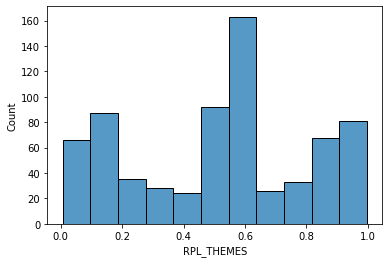

In [33]:
print("Variance of SVI scores of sample: {}".format(np.nanvar(df_sample['RPL_THEMES'].values)))
print("Variance of SVI scores of Texas: {}".format(np.nanvar(df_svi_tx['RPL_THEMES'].values)))
print("Average variance of SVI scores: {}".format(np.nanmean(ls_var)))
print("Max SVI score: {}".format(df_sample['RPL_THEMES'].max()))
print("Min SVI score: {}".format(df_sample['RPL_THEMES'].min()))

sns.histplot(data=df_sample['RPL_THEMES'])

## Distribution of SOFA scores

In [34]:
df_sample_pct_sofa = df_sample.groupby(['SOFA']).agg({'deid_fin_encounter': 'count'}).copy()
df_sample_pct_sofa['percentage'] = df_sample_pct_sofa.loc[:, ['deid_fin_encounter']].apply(lambda x: round(x/x.sum(), 2))
df_sample_pct_sofa.rename(columns={'deid_fin_encounter':'count_patient'}, inplace=True)
df_sample_pct_sofa

,count_patient,percentage
SOFA,,
0,147,0.21
1,86,0.12
2,47,0.07
3,67,0.10
4,92,0.13
5,62,0.09
6,49,0.07
7,32,0.05
8,33,0.05


In [35]:
count_race = Counter(df_sample['race_display'])
count_race

Counter({'Hispanic or Latino': 376,
         'White': 259,
         'Black or African American': 61,
         'Asian': 7})

In [36]:
df_left = df_sample.groupby(['SOFA'])[['deid_fin_encounter']].agg('count').reset_index(level=['SOFA'], col_level=1).rename(columns={'deid_fin_encounter': 'num_patients'})
df_tmp = {"SOFA": 16, "num_patients": 0}
df_left = df_left.append(df_tmp, ignore_index=True)
df_tmp = {"SOFA": 18, "num_patients": 0}
df_left = df_left.append(df_tmp, ignore_index=True)
df_left = df_left.sort_values(by=["SOFA"]).reset_index(drop=True)

df_right = df_sample.loc[df_sample['discharge_disposition_display']=='Expired'].groupby(['SOFA'])[['deid_fin_encounter']].agg('count').reset_index(level=['SOFA'], col_level=1).rename(columns={'deid_fin_encounter': 'num_death'})
df_tmp = {"SOFA": 14, "num_death": 0}
df_right = df_right.append(df_tmp, ignore_index=True)
df_tmp = {"SOFA": 16, "num_death": 0}
df_right = df_right.append(df_tmp, ignore_index=True)
df_tmp = {"SOFA": 18, "num_death": 0}
df_right = df_right.append(df_tmp, ignore_index=True)
df_right = df_right.sort_values(by=["SOFA"]).reset_index(drop=True)

In [37]:
df_center = df_left.merge(df_right, on='SOFA', how='left')
df_center['percentage_death'] = round(df_center['num_death']/df_center['num_patients']*100, 0)
df_center

,SOFA,num_patients,num_death,percentage_death
0,0,147,3,2.0
1,1,86,4,5.0
2,2,47,4,9.0
3,3,67,16,24.0
4,4,92,22,24.0
5,5,62,20,32.0
6,6,49,21,43.0
7,7,32,9,28.0
8,8,33,15,45.0
9,9,36,20,56.0


In [38]:
tmp = df_sample.groupby(by=["race_display"]).agg({'deid_fin_encounter': 'count'})
tmp['percentage'] = tmp.loc[:, ['deid_fin_encounter']].apply(lambda x: round(x/x.sum(), 2))
tmp.rename(columns={'deid_fin_encounter':'count_patient'}, inplace=True)
tmp = tmp.reset_index()
tmp

,race_display,count_patient,percentage
0,Asian,7,0.01
1,Black or African American,61,0.09
2,Hispanic or Latino,376,0.53
3,White,259,0.37


<AxesSubplot:xlabel='race_display', ylabel='percentage'>

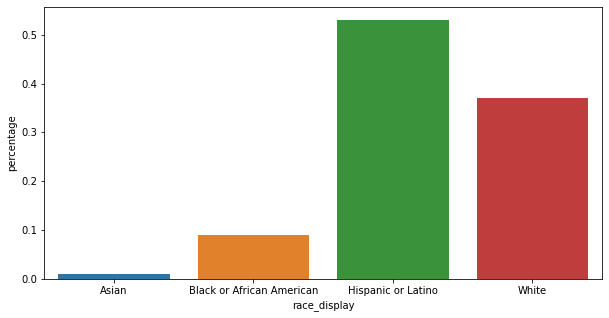

In [39]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(
    data=tmp,
    x="race_display",
    y="percentage"
)

# Develop allocation

In [40]:
iter_simulation = 1000  # The number of simulations

aval_vent = np.linspace(0,1,11)   # Ventilator availability as percentage
aval_vent.round(1)

class Allocation(object):
  
    def __init__(self, df, aval_vent, calibration_mortality_sofa):
        self.patients = df.copy() 
        self.patients['death'] = [0 for _ in range(len(self.patients))] # All patients initially survive
        self.patients['vent'] = [0 for _ in range(len(self.patients))]  # All patients are not initially allocated to a ventilator
        self.num_vent = int(len(self.patients) * aval_vent)            # Number of ventilators available
        self.mortality_sofa = calibration_mortality_sofa              # Mortality for SOFA

    def __run_allocation(self, patients): # Analytical approach
        patients.reset_index(drop=True, inplace=True)
        print('-----------------------------------Number of ventilators available: {}-----------------------------------'.format(self.num_vent))
        for i, patient in patients.iterrows():  # Allocate ventilators to patients

            if patients.loc[patients['vent']==1].shape[0] == self.num_vent: # If no more ventialtors available, then stop allocating ventilators
                break
        
            patients.loc[i, 'vent'] = 1
        
        if (self.num_vent != 0) and (patients.loc[patients.index==(self.num_vent-1), 'SOFA'].values == patients.loc[patients.index==(self.num_vent), 'SOFA'].values): # When a tie occurs
            tie_sofa = patients.loc[patients.index==(self.num_vent-1), 'SOFA'].values # Find SOFA score that causes a tie
            print('-----------------------------------Tie occurs with SOFA: {} and mortality probability: {}-----------------------------------'.format(tie_sofa[0], self.mortality_sofa[tie_sofa[0]]))

            if patients.loc[patients['SOFA']==tie_sofa[0]].first_valid_index() == 0:  # When needed to cut a line from the beginning of the prioritized list

                tie_allocated = patients.loc[(patients['SOFA']==tie_sofa[0]) & (patients['vent']==1)].copy()
                tie_allocated_not = patients.loc[(patients['SOFA']==tie_sofa[0]) & (patients['vent']==0)].copy()
                tie_group = pd.concat([tie_allocated, tie_allocated_not])

                print('-----------------------------------Death for tie group-----------------------------------')
                count_death_tie = self.mortality_tie(tie_group, tie_sofa[0]).copy()
                print('-----------------------------------Death for non-allocated group-----------------------------------')
                count_death_alloc_not = self.mortality_alloc_not(patients.loc[(patients['SOFA']!=tie_sofa[0]) & (patients['vent']==0)].copy())
                print('-----------------------------------Death for all cases-----------------------------------')
                count_death_final = count_death_tie.set_index('race_display').add(count_death_alloc_not.set_index('race_display'), fill_value=0).reset_index()
                count_death_final.rename(columns={'expected_death': 'count_death'}, inplace=True)
                count_death_final = count_death_final[['race_display', 'count_death']]
                count_death_final.drop_duplicates(inplace=True)

                display(count_death_final)
                return count_death_final

            else: # When needed to cut lines in the mid of the prioritized list
                idx_tie_first = patients.loc[patients['SOFA']==tie_sofa[0]].first_valid_index()
                idx_tie_last = patients.loc[patients['SOFA']==tie_sofa[0]].last_valid_index()

                print('-----------------------------------Death for allocated group-----------------------------------')
                count_death_alloc = self.mortality_alloc(patients.loc[:idx_tie_first-1].copy())
                print('-----------------------------------Death for tie group-----------------------------------')
                count_death_tie = self.mortality_tie(patients.loc[idx_tie_first:idx_tie_last], tie_sofa[0]).copy()
                print('-----------------------------------Death for non-allocated group-----------------------------------')
                count_death_alloc_not = self.mortality_alloc_not(patients.loc[idx_tie_last+1:].copy())
                print('-----------------------------------Death for all cases-----------------------------------')
                count_death_final = count_death_alloc.set_index('race_display').add(count_death_tie.set_index('race_display'), fill_value=0).reset_index()
                count_death_final = count_death_final.set_index('race_display').add(count_death_alloc_not.set_index('race_display'), fill_value=0).reset_index()
                count_death_final.rename(columns={'expected_death': 'count_death'}, inplace=True)
                count_death_final = count_death_final[['race_display', 'count_death']]
                count_death_final.drop_duplicates(inplace=True)

                display(count_death_final)
                return count_death_final

        else:   # When a tie dose not occur
            print('-----------------------------------Tie did not occur-----------------------------------')
            if patients.loc[patients['vent']==1].empty == False:
                count_death_alloc = self.mortality_alloc(patients.loc[patients['vent']==1].copy())

            if patients.loc[patients['vent']==0].empty == False:
                count_death_alloc_not = self.mortality_alloc_not(patients.loc[patients['vent']==0].copy())

            if self.num_vent == 0:
                display(count_death_alloc_not)
                return count_death_alloc_not

            elif self.num_vent == len(self.patients):
                display(count_death_alloc)
                return count_death_alloc

            else:
                df_count_death_comb = count_death_alloc.set_index('race_display').add(count_death_alloc_not.set_index('race_display'), fill_value=0).reset_index()
                display(df_count_death_comb)
                return df_count_death_comb
    
    def mortality_alloc(self, patients):
        patients = patients.groupby(['SOFA', 'race_display'])[['deid_fin_encounter']].agg(['count']).copy()
        patients = patients.reset_index(level=['SOFA', 'race_display'], col_level=1)
        patients.columns = patients.columns.droplevel(0)

        for i, value in patients.iterrows():
            patients.loc[i, 'expected_death'] = round(patients.loc[i, 'count'] * self.mortality_sofa[patients.loc[i, 'SOFA']] * 0.01, 2)

        patients = patients.groupby('race_display')[['expected_death']].agg(['sum'])
        patients.rename(columns={'sum': 'expected_death'}, inplace=True)
        patients = patients.reset_index(level=['race_display'], col_level=1)
        patients.columns = patients.columns.droplevel(0)

        return patients
        
    def mortality_alloc_not(self, patients):

        for i, patient in patients.iterrows():
            patients.loc[i, 'death'] = 1  # Assumption in baseline paper

        patients = patients.groupby(['SOFA', 'race_display'])[['death']].agg(['count']).copy()
        patients = patients.reset_index(level=['SOFA', 'race_display'], col_level=1)
        patients.columns = patients.columns.droplevel(0)

        patients = patients.groupby('race_display')[['count']].agg(['sum']).copy()
        patients.rename(columns={'sum': 'expected_death'}, inplace=True)
        patients = patients.reset_index(level=['race_display'], col_level=1)
        patients.columns = patients.columns.droplevel(0)

        return patients

    def mortality_tie(self, patients, tie_sofa):
        patients = patients.groupby(['race_display', 'vent'])[['deid_fin_encounter']].agg(['count']).copy()
        patients = patients.reset_index(level=['race_display', 'vent'], col_level=1)
        patients.columns = patients.columns.droplevel(0)

        for i, value in patients.iterrows():
            # Percentage of patients who allocated to ventilators or not
            patients.loc[i, 'P[NV] & P[V]'] = round(value['count']/patients.loc[patients['race_display']==value['race_display'], 'count'].sum(), 2)

            if value['vent'] == 0:
                # Mortality probability for patients not allocated to ventilators
                patients.loc[i, 'P[D|NV] & P[D|V]'] = round(1.0, 2)
            else:
                # Mortality probability for patients allocated to ventilators according to their SOFA score
                patients.loc[i, 'P[D|NV] & P[D|V]'] = round(self.mortality_sofa[tie_sofa] * 0.01, 2)

            # Percentage of the sub group who are died
            patients.loc[i, 'P[D_sub]'] = patients.loc[i, 'P[NV] & P[V]'] * patients.loc[i, 'P[D|NV] & P[D|V]']

        for cat in patients['race_display'].unique():
            sum_p = patients.loc[patients['race_display']==cat, 'P[D_sub]'].sum()
            patients.loc[patients['race_display']==cat, 'P[D_total]'] = sum_p
            patients.loc[patients['race_display']==cat, 'expected_death'] = patients.loc[patients['race_display']==cat, 'count'].sum() * sum_p

        patients.reset_index(drop=True, inplace=True)

        return patients

    def __run_allocation_simulator(self, patients): # Simulation approach
        patients.reset_index(drop=True, inplace=True)

        for i, patient in patients.iterrows():

            if patients.loc[patients['vent']==1].shape[0] == self.num_vent: # If no more ventialtors available, then stop allocating ventilators
                break
        
            death, vent = self.mortality_alloc_simulator(patient)
        
            patients.loc[i, 'death'] = death
            patients.loc[i, 'vent'] = vent

        patients_alloc = patients.loc[patients['vent']==1].copy()
        patients_alloc_not = patients.loc[patients['vent']==0].copy()
        patients_alloc_not = self.mortality_alloc_not_simulator(patients_alloc_not)

        patients = pd.concat([patients_alloc, patients_alloc_not])
        patients = patients.groupby(['race_display'])[['death']].agg(['sum']).copy()
        patients = patients.reset_index(level=['race_display'], col_level=1)
        patients.columns = patients.columns.droplevel(0)

        return patients    
    
    def mortality_alloc_simulator(self, patient):

        prob = self.mortality_sofa[patient['SOFA']]             # Mortality probability for each SOFA score
        death = np.random.binomial(size=1, n=1, p=prob*.01)[0]  # Death depending on mortality probability

        return death, 1 
    
    def mortality_alloc_not_simulator(self, patients):

        for i, patient in patients.iterrows():
            patients.loc[i, 'death'] = 1

        return patients
    
    def __categorize_age(self, patient):    # Life-cycle consideration delineated in Maryland CSC
        if patient.age_at_admit < 50:
            return 1 
        elif patient.age_at_admit < 70: 
            return 2 
        elif patient.age_at_admit < 85:
            return 3 
        else:
            return 4
    
    def maryland(self):
      
        patients = self.patients.copy()
        patients['cat_age'] = patients.apply(lambda patient: self.__categorize_age(patient), axis=1)  # Categorize patients' age
        patients.sort_values(by=['SOFA', 'count_comorbidity', 'cat_age'], ascending=[True, True, True], inplace=True) # Prioritize patients who have lower SOFA score first, then small amount of comorbidities, and finally are in youger age category first
        patients_allocated = self.__run_allocation(patients)

        return patients_allocated 

    def max_lives_saved(self):

        patients = self.patients.copy()
        patients.sort_values(by=['SOFA'], ascending=True, inplace=True)  # Prioritize patients who have lower SOFA scores first
        patients_allocated = self.__run_allocation(patients)

        return patients_allocated 
    
    def max_life_years(self):

        patients = self.patients.copy()
        patients.sort_values(by=['SOFA', 'life_years'], ascending=[True,False], inplace=True)  # Prioritize patients who have lower SOFA scores and then more life years to live
        patients_allocated = self.__run_allocation(patients)

        return patients_allocated 
    
    def youngest(self):

        patients = self.patients.copy()
        patients.sort_values(by=['age_at_admit'], ascending=True, inplace=True)  # Prioritize patients who are younger first
        patients_allocated = self.__run_allocation(patients)

        return patients_allocated 
        
    def sickest(self):

        patients = self.patients.copy()
        patients.sort_values(by=['SOFA'], ascending=False, inplace=True) # Prioritize patients who have higher SOFA scores first
        patients_allocated = self.__run_allocation(patients)

        return patients_allocated

    def new_york(self):

        patients = self.patients.copy()  # Prioritize patients by shuffling orders within patients having the same SOFA scores
        group_sofa = [df for _, df in patients.groupby('SOFA')]          # Group patients based on SOFA scores
        random.shuffle(group_sofa)                                       # Shuffle patients in each SOFA score group randomly
        patients = pd.concat(group_sofa).reset_index(drop=True)          # Re-combine groups seperated by SOFA scores
        patients.sort_values('SOFA', ascending=True, inplace=True)       # Sort patients by SOFA scores in ascending order
        patients_allocated = self.__run_allocation_simulator(patients)

        return patients_allocated

    def lottery(self):

        patients = self.patients.copy()
        patients = patients.sample(frac=1)  # Prioritize patients by shuffling them
        patients_allocated = self.__run_allocation_simulator(patients)

        return patients_allocated 
        

# Allocate ventilators (Baseline)

In [41]:
death_base = Counter(df_sample.loc[df_sample['discharge_disposition_display']=='Expired']['race_display'])
death_base = pd.DataFrame(death_base.items(), columns=['race', 'count_death'])
death_base['percentage_death'] = death_base.apply(lambda row: percentage_death(row), axis=1)  # Ratio of death for each racial group from total deaths
death_base['avg_death'] = death_base['count_death'].mean() # Average of deaths for all racial groups
death_base['type_allocation'] = 'Baseline'
death_base['aval'] = 2.0   # Nothing about scarcity level
death_base

,race,count_death,percentage_death,avg_death,type_allocation,aval
0,Hispanic or Latino,90,23.936170,40.5,Baseline,2.0
1,White,52,20.077220,40.5,Baseline,2.0
2,Black or African American,17,27.868852,40.5,Baseline,2.0
3,Asian,3,42.857143,40.5,Baseline,2.0


# Allocate ventilators (Analytical approach)

## Maryland

In [42]:
ls_death = []

for aval in aval_vent:
    print('-----------------------------------Ventilator Availability(%): {}-----------------------------------'.format(round(aval, 1)))
    allocation = Allocation(df_sample, aval, calibration_mortality_sofa)   # Generate Allocation object
    death = allocation.maryland()                                      # Prioritize patients following Maryland CSC
    death.rename(columns={'race_display': 'race', 'expected_death': 'count_death'}, inplace=True)
    death['percentage_death'] = death.apply(lambda row: percentage_death(row), axis=1).round(2)
    death['avg_death'] = statistics.mean(death.loc[: ,'count_death'])
    death['aval'] = round(aval, 1)
    ls_death.append(death)

death_maryland = pd.concat(ls_death)
death_maryland['type_allocation'] = 'Maryland'
death_maryland = pd.concat([death_base, death_maryland])
death_maryland[['count_death', 'percentage_death', 'avg_death']] = death_maryland[['count_death', 'percentage_death', 'avg_death']].round(0).astype(int)
death_maryland.reset_index(drop=True, inplace=True)
display(death_maryland)

-----------------------------------Ventilator Availability(%): 0.0-----------------------------------
-----------------------------------Number of ventilators available: 0-----------------------------------
-----------------------------------Tie did not occur-----------------------------------


,race_display,expected_death
0,Asian,7
1,Black or African American,61
2,Hispanic or Latino,376
3,White,259


-----------------------------------Ventilator Availability(%): 0.1-----------------------------------
-----------------------------------Number of ventilators available: 70-----------------------------------
-----------------------------------Tie occurs with SOFA: 0 and mortality probability: 0.0-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,7.00
1,Black or African American,57.99
3,Hispanic or Latino,343.75
5,White,223.90


-----------------------------------Ventilator Availability(%): 0.2-----------------------------------
-----------------------------------Number of ventilators available: 140-----------------------------------
-----------------------------------Tie occurs with SOFA: 0 and mortality probability: 0.0-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,7.0
1,Black or African American,54.0
2,Hispanic or Latino,304.0
4,White,197.9


-----------------------------------Ventilator Availability(%): 0.3-----------------------------------
-----------------------------------Number of ventilators available: 210-----------------------------------
-----------------------------------Tie occurs with SOFA: 1 and mortality probability: 0.0-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,6.00
1,Black or African American,48.96
3,Hispanic or Latino,267.85
5,White,169.95


-----------------------------------Ventilator Availability(%): 0.4-----------------------------------
-----------------------------------Number of ventilators available: 281-----------------------------------
-----------------------------------Tie occurs with SOFA: 3 and mortality probability: 6.4-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,4.1300
1,Black or African American,38.4500
2,Hispanic or Latino,242.1802
4,White,140.1500


-----------------------------------Ventilator Availability(%): 0.5-----------------------------------
-----------------------------------Number of ventilators available: 351-----------------------------------
-----------------------------------Tie occurs with SOFA: 4 and mortality probability: 20.2-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,4.130
1,Black or African American,33.770
2,Hispanic or Latino,203.388
4,White,118.620


-----------------------------------Ventilator Availability(%): 0.6-----------------------------------
-----------------------------------Number of ventilators available: 421-----------------------------------
-----------------------------------Tie occurs with SOFA: 4 and mortality probability: 20.2-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,4.130
1,Black or African American,31.370
3,Hispanic or Latino,168.196
5,White,100.124


-----------------------------------Ventilator Availability(%): 0.7-----------------------------------
-----------------------------------Number of ventilators available: 492-----------------------------------
-----------------------------------Tie occurs with SOFA: 5 and mortality probability: 20.2-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,3.330
1,Black or African American,25.780
2,Hispanic or Latino,142.986
4,White,75.554


-----------------------------------Ventilator Availability(%): 0.8-----------------------------------
-----------------------------------Number of ventilators available: 562-----------------------------------
-----------------------------------Tie occurs with SOFA: 7 and mortality probability: 21.5-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,1.7600
1,Black or African American,17.9479
3,Hispanic or Latino,112.2437
5,White,60.5737


-----------------------------------Ventilator Availability(%): 0.9-----------------------------------
-----------------------------------Number of ventilators available: 632-----------------------------------
-----------------------------------Tie occurs with SOFA: 9 and mortality probability: 33.3-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,1.7700
1,Black or African American,13.7000
2,Hispanic or Latino,83.0836
4,White,44.9166


-----------------------------------Ventilator Availability(%): 1.0-----------------------------------
-----------------------------------Number of ventilators available: 703-----------------------------------
-----------------------------------Tie did not occur-----------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


,race_display,expected_death
0,Asian,1.27
1,Black or African American,11.38
2,Hispanic or Latino,65.36
3,White,36.72


,race,count_death,percentage_death,avg_death,type_allocation,aval
0,Hispanic or Latino,90,24,40,Baseline,2.0
1,White,52,20,40,Baseline,2.0
2,Black or African American,17,28,40,Baseline,2.0
3,Asian,3,43,40,Baseline,2.0
4,Asian,7,100,176,Maryland,0.0
5,Black or African American,61,100,176,Maryland,0.0
6,Hispanic or Latino,376,100,176,Maryland,0.0
7,White,259,100,176,Maryland,0.0
8,Asian,7,100,158,Maryland,0.1
9,Black or African American,58,95,158,Maryland,0.1


In [43]:
maryland = death_maryland.loc[death_maryland['aval']!='Baseline', ['race', 'count_death', 'type_allocation', 'aval']].copy()
display(maryland)

,race,count_death,type_allocation,aval
0,Hispanic or Latino,90,Baseline,2.0
1,White,52,Baseline,2.0
2,Black or African American,17,Baseline,2.0
3,Asian,3,Baseline,2.0
4,Asian,7,Maryland,0.0
5,Black or African American,61,Maryland,0.0
6,Hispanic or Latino,376,Maryland,0.0
7,White,259,Maryland,0.0
8,Asian,7,Maryland,0.1
9,Black or African American,58,Maryland,0.1


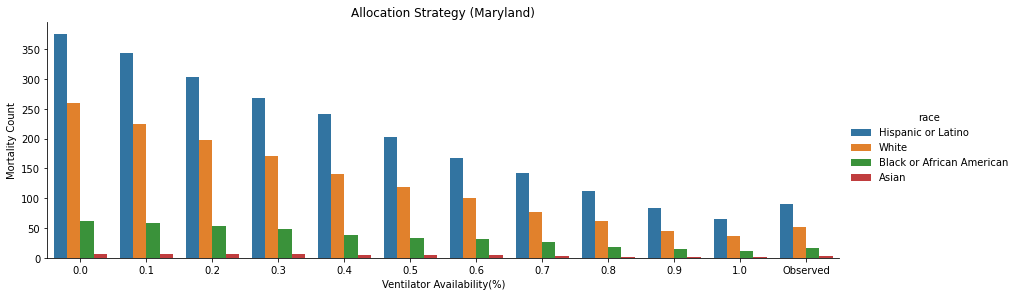

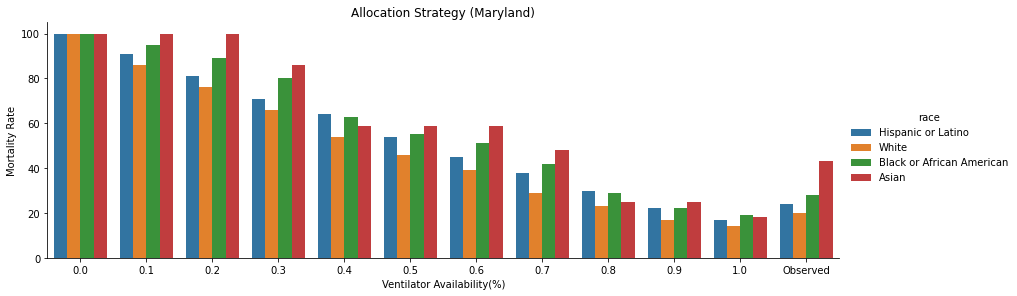

In [44]:
visualize_count_mortality(death_maryland, 'Maryland')
visualize_percentage_mortality(death_maryland, 'Maryland')

## Max Lives Years

In [45]:
ls_death = []

for aval in aval_vent:
    print('------------------------------{}------------------------------'.format(round(aval, 1)))
    allocation = Allocation(df_sample, aval, calibration_mortality_sofa)   # Generate Allocation object
    death = allocation.max_life_years()                                         # Prioritize patients following Maryland CSC
    death.rename(columns={'race_display': 'race', 'expected_death': 'count_death'}, inplace=True)
    death['percentage_death'] = death.apply(lambda row: percentage_death(row), axis=1)
    death['avg_death'] = statistics.mean(death.loc[: ,'count_death'])
    death['aval'] = round(aval, 1)
    ls_death.append(death)

death_max_lives_years = pd.concat(ls_death)
death_max_lives_years['type_allocation'] = 'Max Lives Years'
death_max_lives_years = pd.concat([death_base, death_max_lives_years])
death_max_lives_years[['count_death', 'percentage_death', 'avg_death',]] = death_max_lives_years[['count_death', 'percentage_death', 'avg_death']].round(0).astype(int)
death_max_lives_years.reset_index(drop=True, inplace=True)
display(death_max_lives_years)

------------------------------0.0------------------------------
-----------------------------------Number of ventilators available: 0-----------------------------------
-----------------------------------Tie did not occur-----------------------------------


,race_display,expected_death
0,Asian,7
1,Black or African American,61
2,Hispanic or Latino,376
3,White,259


------------------------------0.1------------------------------
-----------------------------------Number of ventilators available: 70-----------------------------------
-----------------------------------Tie occurs with SOFA: 0 and mortality probability: 0.0-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,7.00
1,Black or African American,56.03
3,Hispanic or Latino,345.25
5,White,225.20


------------------------------0.2------------------------------
-----------------------------------Number of ventilators available: 140-----------------------------------
-----------------------------------Tie occurs with SOFA: 0 and mortality probability: 0.0-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,7.00
1,Black or African American,54.00
2,Hispanic or Latino,303.25
4,White,199.20


------------------------------0.3------------------------------
-----------------------------------Number of ventilators available: 210-----------------------------------
-----------------------------------Tie occurs with SOFA: 1 and mortality probability: 0.0-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,6.00
1,Black or African American,47.97
3,Hispanic or Latino,270.19
5,White,168.84


------------------------------0.4------------------------------
-----------------------------------Number of ventilators available: 281-----------------------------------
-----------------------------------Tie occurs with SOFA: 3 and mortality probability: 6.4-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,4.13
1,Black or African American,37.51
3,Hispanic or Latino,243.28
4,White,140.15


------------------------------0.5------------------------------
-----------------------------------Number of ventilators available: 351-----------------------------------
-----------------------------------Tie occurs with SOFA: 4 and mortality probability: 20.2-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,4.130
1,Black or African American,33.770
2,Hispanic or Latino,204.236
4,White,117.804


------------------------------0.6------------------------------
-----------------------------------Number of ventilators available: 421-----------------------------------
-----------------------------------Tie occurs with SOFA: 4 and mortality probability: 20.2-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,3.330
1,Black or African American,32.170
3,Hispanic or Latino,170.740
5,White,97.948


------------------------------0.7------------------------------
-----------------------------------Number of ventilators available: 492-----------------------------------
-----------------------------------Tie occurs with SOFA: 5 and mortality probability: 20.2-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,3.330
1,Black or African American,27.364
3,Hispanic or Latino,141.962
5,White,74.594


------------------------------0.8------------------------------
-----------------------------------Number of ventilators available: 562-----------------------------------
-----------------------------------Tie occurs with SOFA: 7 and mortality probability: 21.5-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,1.7600
1,Black or African American,17.9479
3,Hispanic or Latino,112.2437
5,White,60.5737


------------------------------0.9------------------------------
-----------------------------------Number of ventilators available: 632-----------------------------------
-----------------------------------Tie occurs with SOFA: 9 and mortality probability: 33.3-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,1.7700
1,Black or African American,13.0300
2,Hispanic or Latino,84.3499
4,White,44.2600


------------------------------1.0------------------------------
-----------------------------------Number of ventilators available: 703-----------------------------------
-----------------------------------Tie did not occur-----------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


,race_display,expected_death
0,Asian,1.27
1,Black or African American,11.38
2,Hispanic or Latino,65.36
3,White,36.72


,race,count_death,percentage_death,avg_death,type_allocation,aval
0,Hispanic or Latino,90,24,40,Baseline,2.0
1,White,52,20,40,Baseline,2.0
2,Black or African American,17,28,40,Baseline,2.0
3,Asian,3,43,40,Baseline,2.0
4,Asian,7,100,176,Max Lives Years,0.0
5,Black or African American,61,100,176,Max Lives Years,0.0
6,Hispanic or Latino,376,100,176,Max Lives Years,0.0
7,White,259,100,176,Max Lives Years,0.0
8,Asian,7,100,158,Max Lives Years,0.1
9,Black or African American,56,92,158,Max Lives Years,0.1


In [46]:
max_lives_years = death_max_lives_years.loc[death_max_lives_years['aval']!=2.0, ['race', 'count_death', 'type_allocation', 'aval']].copy()
display(max_lives_years)

,race,count_death,type_allocation,aval
4,Asian,7,Max Lives Years,0.0
5,Black or African American,61,Max Lives Years,0.0
6,Hispanic or Latino,376,Max Lives Years,0.0
7,White,259,Max Lives Years,0.0
8,Asian,7,Max Lives Years,0.1
9,Black or African American,56,Max Lives Years,0.1
10,Hispanic or Latino,345,Max Lives Years,0.1
11,White,225,Max Lives Years,0.1
12,Asian,7,Max Lives Years,0.2
13,Black or African American,54,Max Lives Years,0.2


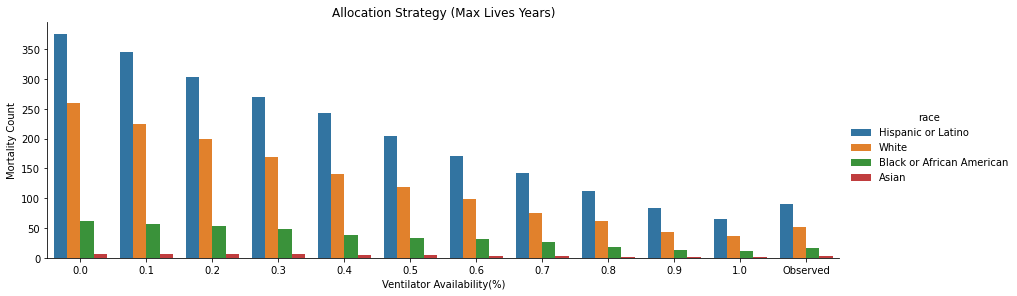

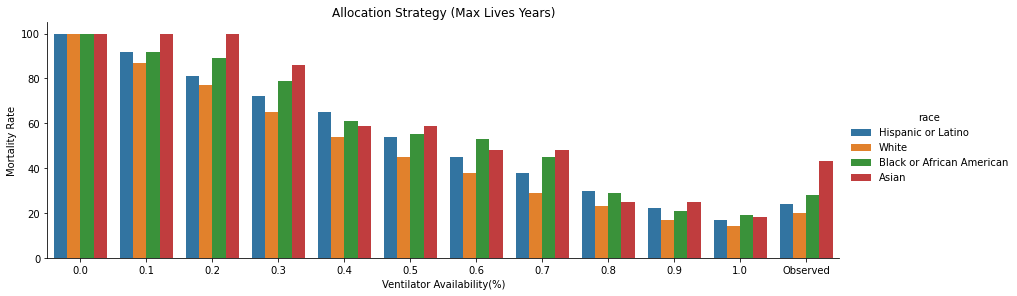

In [47]:
visualize_count_mortality(death_max_lives_years, 'Max Lives Years')
visualize_percentage_mortality(death_max_lives_years, 'Max Lives Years')

## Youngest First

In [48]:
ls_death = []

for aval in aval_vent:
    print('------------------------------{}------------------------------'.format(round(aval, 1)))
    allocation = Allocation(df_sample, aval, calibration_mortality_sofa)    # Generate Allocation object
    death = allocation.youngest()                                           # Prioritize patients following Maryland CSC
    death.rename(columns={'race_display': 'race', 'expected_death': 'count_death'}, inplace=True)
    death['percentage_death'] = death.apply(lambda row: percentage_death(row), axis=1)
    death['avg_death'] = statistics.mean(death.loc[: ,'count_death'])
    death['aval'] = round(aval, 1)
    ls_death.append(death)

death_youngest = pd.concat(ls_death)
death_youngest['type_allocation'] = 'Youngest'
death_youngest = pd.concat([death_base, death_youngest])
death_youngest[['count_death', 'percentage_death', 'avg_death']] = death_youngest[['count_death', 'percentage_death', 'avg_death']].round(0).astype(int)
death_youngest.reset_index(drop=True, inplace=True)
display(death_youngest)

------------------------------0.0------------------------------
-----------------------------------Number of ventilators available: 0-----------------------------------
-----------------------------------Tie did not occur-----------------------------------


,race_display,expected_death
0,Asian,7
1,Black or African American,61
2,Hispanic or Latino,376
3,White,259


------------------------------0.1------------------------------
-----------------------------------Number of ventilators available: 70-----------------------------------
-----------------------------------Tie did not occur-----------------------------------


,race_display,expected_death
0,Asian,6.06
1,Black or African American,53.83
2,Hispanic or Latino,342.08
3,White,237.39


------------------------------0.2------------------------------
-----------------------------------Number of ventilators available: 140-----------------------------------
-----------------------------------Tie did not occur-----------------------------------


,race_display,expected_death
0,Asian,4.28
1,Black or African American,51.39
2,Hispanic or Latino,303.13
3,White,219.53


------------------------------0.3------------------------------
-----------------------------------Number of ventilators available: 210-----------------------------------
-----------------------------------Tie did not occur-----------------------------------


,race_display,expected_death
0,Asian,4.28
1,Black or African American,47.46
2,Hispanic or Latino,270.91
3,White,196.84


------------------------------0.4------------------------------
-----------------------------------Number of ventilators available: 281-----------------------------------
-----------------------------------Tie did not occur-----------------------------------


,race_display,expected_death
0,Asian,3.35
1,Black or African American,45.36
2,Hispanic or Latino,236.03
3,White,178.01


------------------------------0.5------------------------------
-----------------------------------Number of ventilators available: 351-----------------------------------
-----------------------------------Tie occurs with SOFA: 2 and mortality probability: 6.4-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,2.3282
2,Black or African American,37.3214
4,Hispanic or Latino,188.8732
6,White,145.4574


------------------------------0.6------------------------------
-----------------------------------Number of ventilators available: 421-----------------------------------
-----------------------------------Tie did not occur-----------------------------------


,race_display,expected_death
0,Asian,2.57
1,Black or African American,36.45
2,Hispanic or Latino,170.84
3,White,137.68


------------------------------0.7------------------------------
-----------------------------------Number of ventilators available: 492-----------------------------------
-----------------------------------Tie did not occur-----------------------------------


,race_display,expected_death
0,Asian,2.57
1,Black or African American,30.43
2,Hispanic or Latino,140.37
3,White,115.99


------------------------------0.8------------------------------
-----------------------------------Number of ventilators available: 562-----------------------------------
-----------------------------------Tie did not occur-----------------------------------


,race_display,expected_death
0,Asian,1.27
1,Black or African American,24.69
2,Hispanic or Latino,114.97
3,White,90.65


------------------------------0.9------------------------------
-----------------------------------Number of ventilators available: 632-----------------------------------
-----------------------------------Tie did not occur-----------------------------------


,race_display,expected_death
0,Asian,1.27
1,Black or African American,18.17
2,Hispanic or Latino,90.05
3,White,65.67


------------------------------1.0------------------------------
-----------------------------------Number of ventilators available: 703-----------------------------------
-----------------------------------Tie did not occur-----------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


,race_display,expected_death
0,Asian,1.27
1,Black or African American,11.38
2,Hispanic or Latino,65.36
3,White,36.72


,race,count_death,percentage_death,avg_death,type_allocation,aval
0,Hispanic or Latino,90,24,40,Baseline,2.0
1,White,52,20,40,Baseline,2.0
2,Black or African American,17,28,40,Baseline,2.0
3,Asian,3,43,40,Baseline,2.0
4,Asian,7,100,176,Youngest,0.0
5,Black or African American,61,100,176,Youngest,0.0
6,Hispanic or Latino,376,100,176,Youngest,0.0
7,White,259,100,176,Youngest,0.0
8,Asian,6,87,160,Youngest,0.1
9,Black or African American,54,88,160,Youngest,0.1


In [49]:
youngest = death_youngest.loc[death_youngest['aval']!=2.0, ['race', 'count_death', 'type_allocation', 'aval']].copy()
display(youngest)

,race,count_death,type_allocation,aval
4,Asian,7,Youngest,0.0
5,Black or African American,61,Youngest,0.0
6,Hispanic or Latino,376,Youngest,0.0
7,White,259,Youngest,0.0
8,Asian,6,Youngest,0.1
9,Black or African American,54,Youngest,0.1
10,Hispanic or Latino,342,Youngest,0.1
11,White,237,Youngest,0.1
12,Asian,4,Youngest,0.2
13,Black or African American,51,Youngest,0.2


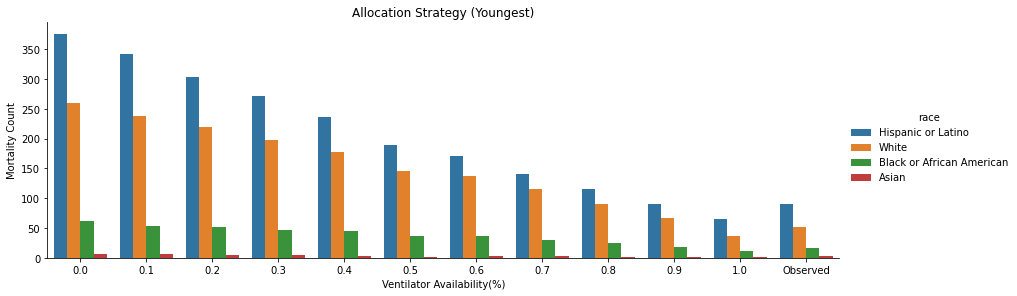

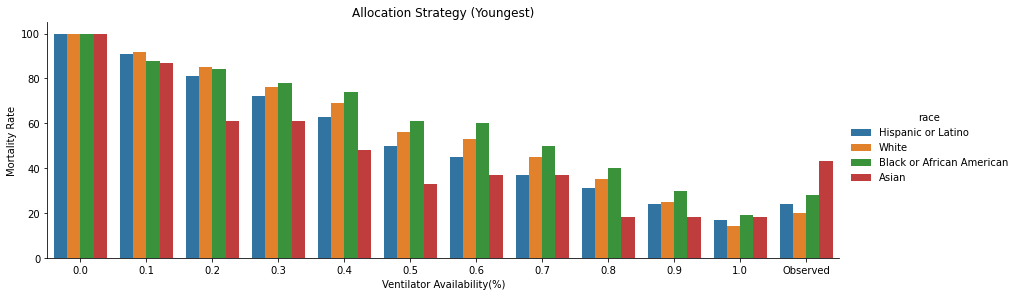

In [50]:
visualize_count_mortality(death_youngest, 'Youngest')
visualize_percentage_mortality(death_youngest, 'Youngest')

## Sickest First

In [51]:
ls_death = []

for aval in aval_vent:
    print('------------------------------{}------------------------------'.format(round(aval, 1)))
    allocation = Allocation(df_sample, aval, calibration_mortality_sofa)   # Generate Allocation object
    death = allocation.sickest()                                         # Prioritize patients following Maryland CSC
    death.rename(columns={'race_display': 'race', 'expected_death': 'count_death'}, inplace=True)
    death['percentage_death'] = death.apply(lambda row: percentage_death(row), axis=1)
    death['avg_death'] = statistics.mean(death.loc[: ,'count_death'])
    death['aval'] = round(aval, 1)
    ls_death.append(death)

death_sickest = pd.concat(ls_death)
death_sickest['type_allocation'] = 'Sickest'
death_sickest = pd.concat([death_base, death_sickest])
death_sickest[['count_death', 'percentage_death', 'avg_death']] = death_sickest[['count_death', 'percentage_death', 'avg_death']].round(0).astype(int)
death_sickest.reset_index(drop=True, inplace=True)
display(death_sickest)

------------------------------0.0------------------------------
-----------------------------------Number of ventilators available: 0-----------------------------------
-----------------------------------Tie did not occur-----------------------------------


,race_display,expected_death
0,Asian,7
1,Black or African American,61
2,Hispanic or Latino,376
3,White,259


------------------------------0.1------------------------------
-----------------------------------Number of ventilators available: 70-----------------------------------
-----------------------------------Tie occurs with SOFA: 9 and mortality probability: 33.3-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,6.5000
1,Black or African American,58.6800
2,Hispanic or Latino,360.3269
4,White,249.4502


------------------------------0.2------------------------------
-----------------------------------Number of ventilators available: 140-----------------------------------
-----------------------------------Tie occurs with SOFA: 7 and mortality probability: 21.5-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,5.7100
1,Black or African American,55.2279
3,Hispanic or Latino,329.0263
5,White,235.8684


------------------------------0.3------------------------------
-----------------------------------Number of ventilators available: 210-----------------------------------
-----------------------------------Tie occurs with SOFA: 5 and mortality probability: 20.2-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,4.940
1,Black or African American,46.590
2,Hispanic or Latino,298.314
4,White,221.076


------------------------------0.4------------------------------
-----------------------------------Number of ventilators available: 281-----------------------------------
-----------------------------------Tie occurs with SOFA: 4 and mortality probability: 20.2-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,4.940
1,Black or African American,41.000
3,Hispanic or Latino,267.966
5,White,200.150


------------------------------0.5------------------------------
-----------------------------------Number of ventilators available: 351-----------------------------------
-----------------------------------Tie occurs with SOFA: 4 and mortality probability: 20.2-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,4.140
1,Black or African American,38.600
2,Hispanic or Latino,237.014
4,White,178.662


------------------------------0.6------------------------------
-----------------------------------Number of ventilators available: 421-----------------------------------
-----------------------------------Tie occurs with SOFA: 3 and mortality probability: 6.4-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,4.1400
1,Black or African American,34.8500
3,Hispanic or Latino,199.0198
5,White,155.4800


------------------------------0.7------------------------------
-----------------------------------Number of ventilators available: 492-----------------------------------
-----------------------------------Tie occurs with SOFA: 1 and mortality probability: 0.0-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,1.27
1,Black or African American,26.39
3,Hispanic or Latino,171.17
5,White,126.88


------------------------------0.8------------------------------
-----------------------------------Number of ventilators available: 562-----------------------------------
-----------------------------------Tie occurs with SOFA: 0 and mortality probability: 0.0-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,1.27
1,Black or African American,18.38
2,Hispanic or Latino,138.11
4,White,97.82


------------------------------0.9------------------------------
-----------------------------------Number of ventilators available: 632-----------------------------------
-----------------------------------Tie occurs with SOFA: 0 and mortality probability: 0.0-----------------------------------
-----------------------------------Death for allocated group-----------------------------------
-----------------------------------Death for tie group-----------------------------------
-----------------------------------Death for non-allocated group-----------------------------------
-----------------------------------Death for all cases-----------------------------------


,race_display,count_death
0,Asian,1.27
1,Black or African American,16.35
3,Hispanic or Latino,98.36
5,White,69.87


------------------------------1.0------------------------------
-----------------------------------Number of ventilators available: 703-----------------------------------
-----------------------------------Tie did not occur-----------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


,race_display,expected_death
0,Asian,1.27
1,Black or African American,11.38
2,Hispanic or Latino,65.36
3,White,36.72


,race,count_death,percentage_death,avg_death,type_allocation,aval
0,Hispanic or Latino,90,24,40,Baseline,2.0
1,White,52,20,40,Baseline,2.0
2,Black or African American,17,28,40,Baseline,2.0
3,Asian,3,43,40,Baseline,2.0
4,Asian,7,100,176,Sickest,0.0
5,Black or African American,61,100,176,Sickest,0.0
6,Hispanic or Latino,376,100,176,Sickest,0.0
7,White,259,100,176,Sickest,0.0
8,Asian,6,93,169,Sickest,0.1
9,Black or African American,59,96,169,Sickest,0.1


In [52]:
sickest = death_sickest.loc[death_sickest['aval']!=2.0, ['race', 'count_death', 'type_allocation', 'aval']].copy()
display(sickest)

,race,count_death,type_allocation,aval
4,Asian,7,Sickest,0.0
5,Black or African American,61,Sickest,0.0
6,Hispanic or Latino,376,Sickest,0.0
7,White,259,Sickest,0.0
8,Asian,6,Sickest,0.1
9,Black or African American,59,Sickest,0.1
10,Hispanic or Latino,360,Sickest,0.1
11,White,249,Sickest,0.1
12,Asian,6,Sickest,0.2
13,Black or African American,55,Sickest,0.2


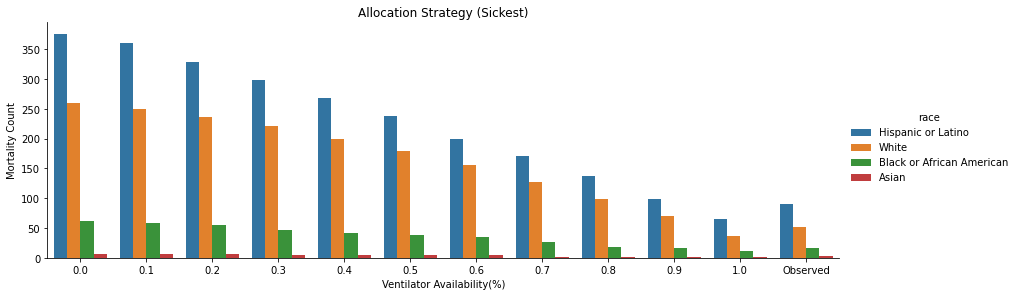

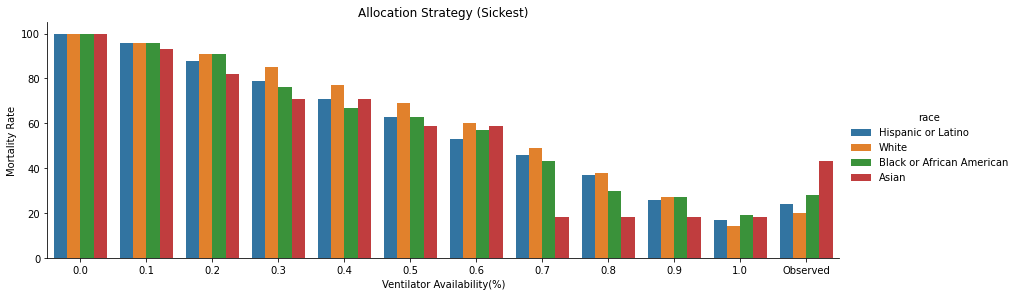

In [53]:
visualize_count_mortality(death_sickest, 'Sickest')
visualize_percentage_mortality(death_sickest, 'Sickest')

# Allocate ventilators (Simulation)

## New York

In [54]:
ls_death_aval = [] # Store dataframes for all scarcity levels

for aval in aval_vent:
    print('-------------------------{}-------------------------'.format(round(aval,1)))
    ls_death_iter = []    # Store dataframes of death counts within iteration

    for _ in range(iter_simulation): # Iterate 1000 times per scarcity level
        # Allocate ventilators to patients
        allocation = Allocation(df_sample, aval, calibration_mortality_sofa)
        death = allocation.new_york()
        ls_death_iter.append(death)
  
    death_aval = pd.concat(ls_death_iter)
    death_aval.rename(columns={'race_display': 'race', 'sum': 'count_death'}, inplace=True)
    death_aval = death_aval.groupby('race').agg(['mean']).round(0).astype(int)
    death_aval = death_aval.reset_index(level=['race'], col_level=1)
    death_aval.columns = death_aval.columns.droplevel(0)
    death_aval.rename(columns={'mean': 'count_death'}, inplace=True)
    death_aval['percentage_death'] = death_aval.apply(lambda row: percentage_death(row), axis=1)
    death_aval['avg_death'] = statistics.mean(death_aval.loc[: ,'count_death'])
    death_aval['type_allocation'] = 'New York'
    death_aval['aval'] = round(aval, 1)
    ls_death_aval.append(death_aval)

death_new_york = pd.concat(ls_death_aval)
death_new_york = pd.concat([death_base, death_new_york])
death_new_york[['count_death', 'percentage_death', 'avg_death']] = death_new_york[['count_death', 'percentage_death', 'avg_death']].round(0).astype(int)

-------------------------0.0-------------------------
-------------------------0.1-------------------------
-------------------------0.2-------------------------
-------------------------0.3-------------------------
-------------------------0.4-------------------------
-------------------------0.5-------------------------
-------------------------0.6-------------------------
-------------------------0.7-------------------------
-------------------------0.8-------------------------
-------------------------0.9-------------------------
-------------------------1.0-------------------------


In [55]:
new_york = death_new_york.loc[death_new_york['aval']!=2.0, ['race', 'count_death', 'type_allocation', 'aval']].copy()
display(new_york)

,race,count_death,type_allocation,aval
0,Asian,7,New York,0.0
1,Black or African American,61,New York,0.0
2,Hispanic or Latino,376,New York,0.0
3,White,259,New York,0.0
0,Asian,7,New York,0.1
1,Black or African American,58,New York,0.1
2,Hispanic or Latino,339,New York,0.1
3,White,229,New York,0.1
0,Asian,7,New York,0.2
1,Black or African American,54,New York,0.2


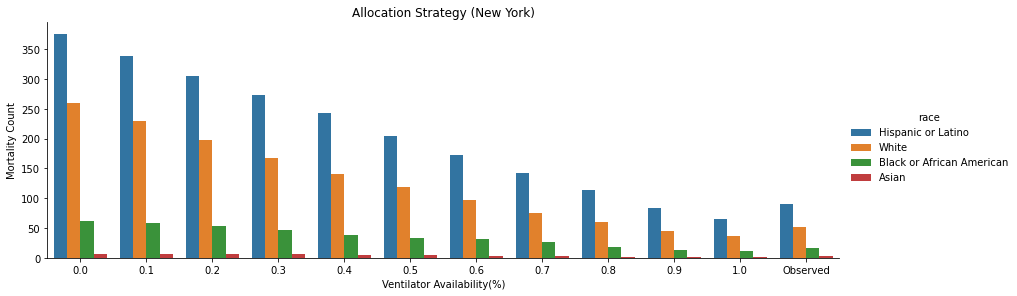

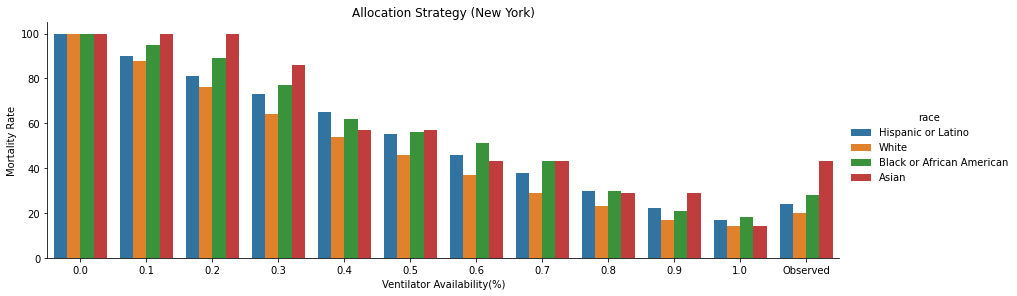

In [56]:
visualize_count_mortality(death_new_york, 'New York')
visualize_percentage_mortality(death_new_york, 'New York')

## Lottery

In [57]:
ls_death_aval = [] # Store dataframes for all scarcity levels

for aval in aval_vent:
    print('-------------------------{}-------------------------'.format(round(aval,1)))
    ls_death_iter = []    # Store dataframes of death counts within iteration

    for _ in range(iter_simulation): # Iterate 1000 times per scarcity level
        # Allocate ventilators to patients
        allocation = Allocation(df_sample, aval, calibration_mortality_sofa)
        death = allocation.new_york()
        ls_death_iter.append(death)
  
    death_aval = pd.concat(ls_death_iter)
    death_aval.rename(columns={'race_display': 'race', 'sum': 'count_death'}, inplace=True)
    death_aval = death_aval.groupby('race').agg(['mean']).round(0).astype(int)
    death_aval = death_aval.reset_index(level=['race'], col_level=1)
    death_aval.columns = death_aval.columns.droplevel(0)
    death_aval.rename(columns={'mean': 'count_death'}, inplace=True)
    death_aval['percentage_death'] = death_aval.apply(lambda row: percentage_death(row), axis=1)
    death_aval['avg_death'] = statistics.mean(death_aval.loc[: ,'count_death'])
    death_aval['type_allocation'] = 'Lottery'
    death_aval['aval'] = round(aval, 1)
    ls_death_aval.append(death_aval)

death_lottery = pd.concat(ls_death_aval)
death_lottery = pd.concat([death_base, death_lottery])
death_lottery[['count_death', 'percentage_death', 'avg_death']] = death_lottery[['count_death', 'percentage_death', 'avg_death']].round(0).astype(int)

-------------------------0.0-------------------------
-------------------------0.1-------------------------
-------------------------0.2-------------------------
-------------------------0.3-------------------------
-------------------------0.4-------------------------
-------------------------0.5-------------------------
-------------------------0.6-------------------------
-------------------------0.7-------------------------
-------------------------0.8-------------------------
-------------------------0.9-------------------------
-------------------------1.0-------------------------


In [58]:
lottery = death_lottery.loc[death_lottery['aval']!=2.0, ['race', 'count_death', 'type_allocation', 'aval']].copy()
display(lottery)

,race,count_death,type_allocation,aval
0,Asian,7,Lottery,0.0
1,Black or African American,61,Lottery,0.0
2,Hispanic or Latino,376,Lottery,0.0
3,White,259,Lottery,0.0
0,Asian,7,Lottery,0.1
1,Black or African American,58,Lottery,0.1
2,Hispanic or Latino,339,Lottery,0.1
3,White,229,Lottery,0.1
0,Asian,7,Lottery,0.2
1,Black or African American,54,Lottery,0.2


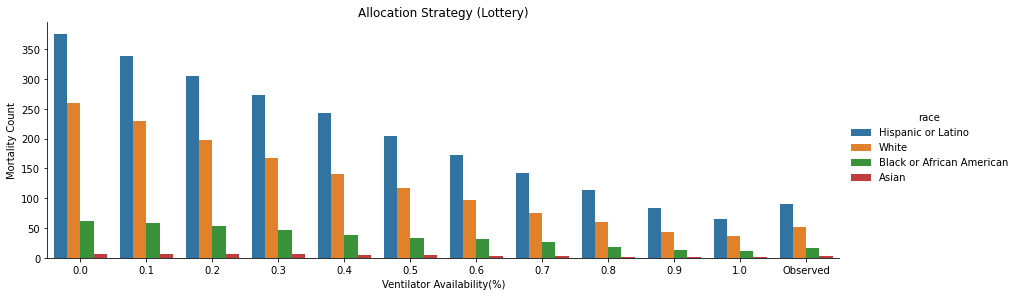

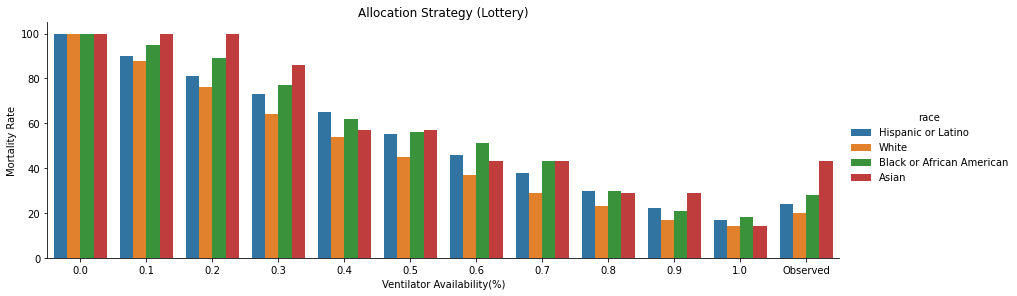

In [59]:
visualize_count_mortality(death_lottery, 'Lottery')
visualize_percentage_mortality(death_lottery, 'Lottery')

# Total

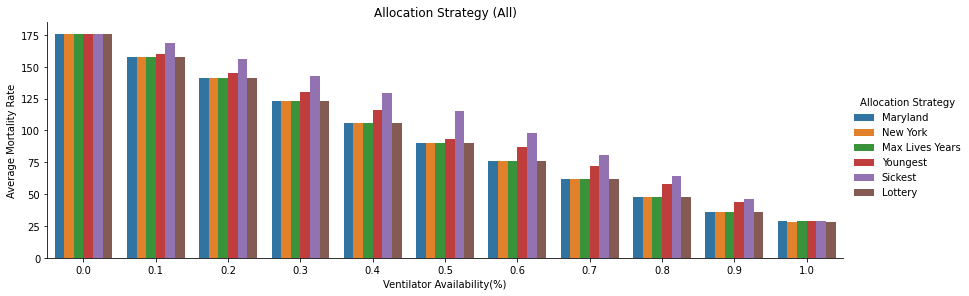

In [60]:
strategies = pd.concat([death_maryland[['avg_death', 'type_allocation', 'aval']], death_new_york[['avg_death', 'type_allocation', 'aval']], death_max_lives_years[['avg_death', 'type_allocation', 'aval']], 
                        death_youngest[['avg_death', 'type_allocation', 'aval']], death_sickest[['avg_death', 'type_allocation', 'aval']], death_lottery[['avg_death', 'type_allocation', 'aval']]])
sns_plot = sns.catplot(x='aval', y='avg_death', hue='type_allocation', data=strategies[strategies['type_allocation']!='Baseline'], kind='bar', legend_out=True, height=4, aspect=3)
plt.title('Allocation Strategy (All)')
sns_plot._legend.set_title('Allocation Strategy')
plt.xlabel('Ventilator Availability(%)')
plt.ylabel('Average Mortality Rate')
sns_plot.savefig("figure/race/percentage_death_total_avg.png")

# Statistics

## Table: Racial group mortality

In [61]:
tb = pd.concat([maryland, new_york, max_lives_years, youngest, sickest, lottery])
tb.reset_index(drop=True, inplace=True)
tb.rename(columns={'type_allocation': 'allocation', 'aval': 'vent availability(%)'}, inplace=True)

for i, value in tb.iterrows():
    if tb.loc[i, 'race']=='Hispanic or Latino':
        tb.loc[i, 'count_patients'] = count_race['Hispanic or Latino']
    elif tb.loc[i, 'race']=='White':
        tb.loc[i, 'count_patients'] = count_race['White']
    elif tb.loc[i, 'race']=='Black or African American':
        tb.loc[i, 'count_patients'] = count_race['Black or African American']
    elif tb.loc[i, 'race']=='Asian':
        tb.loc[i, 'count_patients'] = count_race['Asian']
        
    tb.loc[i, 'mortality rate(%)'] = round(tb.loc[i, 'count_death']/tb.loc[i, 'count_patients']*100, 1)

tb

,race,count_death,allocation,vent availability(%),count_patients,mortality rate(%)
0,Hispanic or Latino,90,Baseline,2.0,376.0,23.9
1,White,52,Baseline,2.0,259.0,20.1
2,Black or African American,17,Baseline,2.0,61.0,27.9
3,Asian,3,Baseline,2.0,7.0,42.9
4,Asian,7,Maryland,0.0,7.0,100.0
...,...,...,...,...,...,...
263,White,44,Lottery,0.9,259.0,17.0
264,Asian,1,Lottery,1.0,7.0,14.3
265,Black or African American,11,Lottery,1.0,61.0,18.0
266,Hispanic or Latino,65,Lottery,1.0,376.0,17.3


In [62]:
cols_order_allocation = ['Maryland', 'New York', 'Max Lives Years', 'Youngest', 'Sickest', 'Lottery']
cols_order_race = ['White', 'Hispanic or Latino', 'Black or African American', 'Asian']
cols_max_min = ['allocation', 0.0, 0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
aval_1_9 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [63]:
tb['allocation'] = tb['allocation'].astype(pd.api.types.CategoricalDtype(categories=cols_order_allocation))
tb['race'] = tb['race'].astype(pd.api.types.CategoricalDtype(categories=cols_order_race))
tb_pivot = tb.pivot_table(values='mortality rate(%)', columns='vent availability(%)', index=['allocation', 'race'])
tb_pivot

vent availability(%)                         0.0    0.1    0.2   0.3   0.4  \
allocation      race                                                         
Maryland        White                      100.0   86.5   76.4  65.6  54.1   
                Hispanic or Latino         100.0   91.5   80.9  71.3  64.4   
                Black or African American  100.0   95.1   88.5  80.3  62.3   
                Asian                      100.0  100.0  100.0  85.7  57.1   
New York        White                      100.0   88.4   76.1  64.5  54.1   
                Hispanic or Latino         100.0   90.2   81.1  72.6  64.6   
                Black or African American  100.0   95.1   88.5  77.0  62.3   
                Asian                      100.0  100.0  100.0  85.7  57.1   
Max Lives Years White                      100.0   86.9   76.8  65.3  54.1   
                Hispanic or Latino         100.0   91.8   80.6  71.8  64.6   
                Black or African American  100.0   91.8   88.5  78.7  62.3   
                Asian                      100.0  100.0  100.0  85.7  57.1   
Youngest        White                      100.0   91.5   84.9  76.1  68.7   
                Hispanic or Latino         100.0   91.0   80.6  72.1  62.8   
                Black or African American  100.0   88.5   83.6  77.0  73.8   
                Asian                      100.0   85.7   57.1  57.1  42.9   
Sickest         White                      100.0   96.1   91.1  85.3  77.2   
                Hispanic or Latino         100.0   95.7   87.5  79.3  71.3   
                Black or African American  100.0   96.7   90.2  77.0  67.2   
                Asian                      100.0   85.7   85.7  71.4  71.4   
Lottery         White                      100.0   88.4   76.1  64.5  54.1   
                Hispanic or Latino         100.0   90.2   81.1  72.6  64.6   
                Black or African American  100.0   95.1   88.5  77.0  62.3   
                Asian                      100.0  100.0  100.0  85.7  57.1   

vent availability(%)                        0.5   0.6   0.7   0.8   0.9   1.0  
allocation      race                                                           
Maryland        White                      45.9  38.6  29.3  23.6  17.4  14.3  
                Hispanic or Latino         54.0  44.7  38.0  29.8  22.1  17.3  
                Black or African American  55.7  50.8  42.6  29.5  23.0  18.0  
                Asian                      57.1  57.1  42.9  28.6  28.6  14.3  
New York        White                      45.6  37.5  29.0  23.2  17.4  14.3  
                Hispanic or Latino         54.5  46.0  38.0  30.1  22.3  17.3  
                Black or African American  55.7  50.8  42.6  29.5  21.3  18.0  
                Asian                      57.1  42.9  42.9  28.6  28.6  14.3  
Max Lives Years White                      45.6  37.8  29.0  23.6  17.0  14.3  
                Hispanic or Latino         54.3  45.5  37.8  29.8  22.3  17.3  
                Black or African American  55.7  52.5  44.3  29.5  21.3  18.0  
                Asian                      57.1  42.9  42.9  28.6  28.6  14.3  
Youngest        White                      56.0  53.3  44.8  35.1  25.5  14.3  
                Hispanic or Latino         50.3  45.5  37.2  30.6  23.9  17.3  
                Black or African American  60.7  59.0  49.2  41.0  29.5  18.0  
                Asian                      28.6  42.9  42.9  14.3  14.3  14.3  
Sickest         White                      69.1  59.8  49.0  37.8  27.0  14.3  
                Hispanic or Latino         63.0  52.9  45.5  36.7  26.1  17.3  
                Black or African American  63.9  57.4  42.6  29.5  26.2  18.0  
                Asian                      57.1  57.1  14.3  14.3  14.3  14.3  
Lottery         White                      45.2  37.5  29.0  23.2  17.0  14.3  
                Hispanic or Latino         54.5  46.0  38.0  30.1  22.3  17.3  
                Black or African American  55.7  50

## Table: Max-Min Difference

In [64]:
tmp = tb_pivot.reset_index(level=['allocation', 'race'], col_level=1)
tmp = tmp.loc[tmp['race']!='Asian', cols_max_min]
tmp.groupby('allocation').agg(['max', 'min'])
diff_max_min = tmp.groupby('allocation').agg(np.ptp)
diff_max_min = diff_max_min.reindex(cols_order_allocation)
diff_max_min

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,0.0,8.6,12.1,14.7,10.3,9.8,12.2,13.3,6.2,5.6,3.7
New York,0.0,6.7,12.4,12.5,10.5,10.1,13.3,13.6,6.9,4.9,3.7
Max Lives Years,0.0,4.9,11.7,13.4,10.5,10.1,14.7,15.3,6.2,5.3,3.7
Youngest,0.0,3.0,4.3,4.9,11.0,10.4,13.5,12.0,10.4,5.6,3.7
Sickest,0.0,1.0,3.6,8.3,10.0,6.1,6.9,6.4,8.3,0.9,3.7
Lottery,0.0,6.7,12.4,12.5,10.5,10.5,13.3,13.6,6.9,5.3,3.7


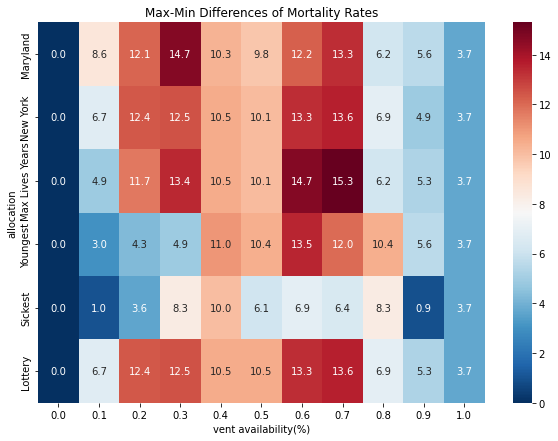

In [65]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(diff_max_min, annot=True, fmt='.1f', cmap='RdBu_r')
plt.title('Max-Min Differences of Mortality Rates')
plt.savefig("figure/race/heat_mortality_diff_max_min_race.png")

In [66]:
display(diff_max_min.mean(axis=1).round(1).to_frame(name='AVG'))
display(diff_max_min.mean(axis=0).round(1).to_frame(name='AVG'))

,AVG
allocation,
Maryland,8.8
New York,8.6
Max Lives Years,8.7
Youngest,7.2
Sickest,5.0
Lottery,8.7


,AVG
vent availability(%),
0.0,0.0
0.1,5.1
0.2,9.4
0.3,11.1
0.4,10.5
0.5,9.5
0.6,12.3
0.7,12.4
0.8,7.5


In [67]:
display(diff_max_min[aval_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
display(diff_max_min[aval_1_9].mean(axis=0).round(1).to_frame(name='AVG'))

,AVG
allocation,
Maryland,10.3
New York,10.1
Max Lives Years,10.2
Youngest,8.3
Sickest,5.7
Lottery,10.2


,AVG
vent availability(%),
0.1,5.1
0.2,9.4
0.3,11.1
0.4,10.5
0.5,9.5
0.6,12.3
0.7,12.4
0.8,7.5
0.9,4.6


## Table: Minority-White Difference (Reference Point: Best Group)

In [68]:
cols_minor_white = ['allocation', 'race', 0.0, 0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
tmp = tb_pivot.reset_index(level=['allocation', 'race'], col_level=1)
tmp = tmp.loc[tmp['race']!='Asian', cols_minor_white]
df_h = tmp.loc[tmp['race']=='Hispanic or Latino', ['allocation', 0.0, 0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]].set_index('allocation')
df_b = tmp.loc[tmp['race']=='Black or African American', ['allocation', 0.0, 0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]].set_index('allocation')
df_w = tmp.loc[tmp['race']=='White', ['allocation', 0.0, 0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]].set_index('allocation')

### Hispanic-White (Absolute Difference)

In [69]:
diff_h_w_ab = df_h.subtract(df_w)
diff_h_w_ab

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,0.0,5.0,4.5,5.7,10.3,8.1,6.1,8.7,6.2,4.7,3.0
New York,0.0,1.8,5.0,8.1,10.5,8.9,8.5,9.0,6.9,4.9,3.0
Max Lives Years,0.0,4.9,3.8,6.5,10.5,8.7,7.7,8.8,6.2,5.3,3.0
Youngest,0.0,-0.5,-4.3,-4.0,-5.9,-5.7,-7.8,-7.6,-4.5,-1.6,3.0
Sickest,0.0,-0.4,-3.6,-6.0,-5.9,-6.1,-6.9,-3.5,-1.1,-0.9,3.0
Lottery,0.0,1.8,5.0,8.1,10.5,9.3,8.5,9.0,6.9,5.3,3.0


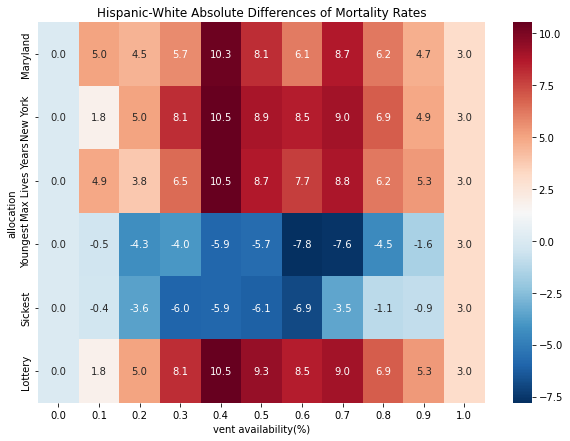

In [70]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(diff_h_w_ab, annot=True, fmt='.1f', cmap='RdBu_r')
plt.title('Hispanic-White Absolute Differences of Mortality Rates')
plt.savefig("figure/race/heat_mortality_diff_h_w_ab.png")

In [71]:
display(diff_h_w_ab.mean(axis=1).round(1).to_frame(name='AVG'))
display(diff_h_w_ab.mean(axis=0).round(1).to_frame(name='AVG'))

,AVG
allocation,
Maryland,5.7
New York,6.1
Max Lives Years,5.9
Youngest,-3.5
Sickest,-2.9
Lottery,6.1


,AVG
vent availability(%),
0.0,0.0
0.1,2.1
0.2,1.7
0.3,3.1
0.4,5.0
0.5,3.9
0.6,2.7
0.7,4.1
0.8,3.4


In [72]:
display(diff_h_w_ab[aval_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
display(diff_h_w_ab[aval_1_9].mean(axis=0).round(1).to_frame(name='AVG'))

,AVG
allocation,
Maryland,6.6
New York,7.1
Max Lives Years,6.9
Youngest,-4.7
Sickest,-3.8
Lottery,7.2


,AVG
vent availability(%),
0.1,2.1
0.2,1.7
0.3,3.1
0.4,5.0
0.5,3.9
0.6,2.7
0.7,4.1
0.8,3.4
0.9,3.0


### Hispanic-White (Relative Difference)

In [73]:
diff_h_w_re = df_h.subtract(df_w)
diff_h_w_re = diff_h_w_re.divide(df_w)*100
diff_h_w_re = diff_h_w_re.round(1)
diff_h_w_re

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,0.0,5.8,5.9,8.7,19.0,17.6,15.8,29.7,26.3,27.0,21.0
New York,0.0,2.0,6.6,12.6,19.4,19.5,22.7,31.0,29.7,28.2,21.0
Max Lives Years,0.0,5.6,4.9,10.0,19.4,19.1,20.4,30.3,26.3,31.2,21.0
Youngest,0.0,-0.5,-5.1,-5.3,-8.6,-10.2,-14.6,-17.0,-12.8,-6.3,21.0
Sickest,0.0,-0.4,-4.0,-7.0,-7.6,-8.8,-11.5,-7.1,-2.9,-3.3,21.0
Lottery,0.0,2.0,6.6,12.6,19.4,20.6,22.7,31.0,29.7,31.2,21.0


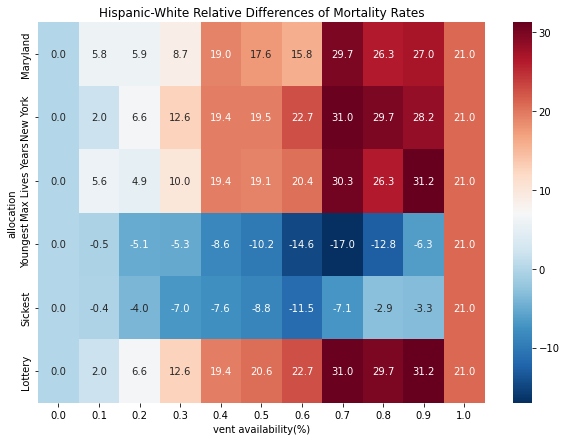

In [74]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(diff_h_w_re, annot=True, fmt='.1f', cmap='RdBu_r')
plt.title('Hispanic-White Relative Differences of Mortality Rates')
plt.savefig("figure/race/heat_mortality_diff_h_w_re.png")

In [75]:
display(diff_h_w_re.mean(axis=1).round(1).to_frame(name='AVG'))
display(diff_h_w_re.mean(axis=0).round(1).to_frame(name='AVG'))

,AVG
allocation,
Maryland,16.1
New York,17.5
Max Lives Years,17.1
Youngest,-5.4
Sickest,-2.9
Lottery,17.9


,AVG
vent availability(%),
0.0,0.0
0.1,2.4
0.2,2.5
0.3,5.3
0.4,10.2
0.5,9.6
0.6,9.2
0.7,16.3
0.8,16.0


In [76]:
display(diff_h_w_re[aval_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
display(diff_h_w_re[aval_1_9].mean(axis=0).round(1).to_frame(name='AVG'))

,AVG
allocation,
Maryland,17.3
New York,19.1
Max Lives Years,18.6
Youngest,-8.9
Sickest,-5.8
Lottery,19.5


,AVG
vent availability(%),
0.1,2.4
0.2,2.5
0.3,5.3
0.4,10.2
0.5,9.6
0.6,9.2
0.7,16.3
0.8,16.0
0.9,18.0


### Black-White (Absolute Difference)

In [77]:
diff_b_w_ab = df_b.subtract(df_w)
diff_b_w_ab

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,0.0,8.6,12.1,14.7,8.2,9.8,12.2,13.3,5.9,5.6,3.7
New York,0.0,6.7,12.4,12.5,8.2,10.1,13.3,13.6,6.3,3.9,3.7
Max Lives Years,0.0,4.9,11.7,13.4,8.2,10.1,14.7,15.3,5.9,4.3,3.7
Youngest,0.0,-3.0,-1.3,0.9,5.1,4.7,5.7,4.4,5.9,4.0,3.7
Sickest,0.0,0.6,-0.9,-8.3,-10.0,-5.2,-2.4,-6.4,-8.3,-0.8,3.7
Lottery,0.0,6.7,12.4,12.5,8.2,10.5,13.3,13.6,6.3,4.3,3.7


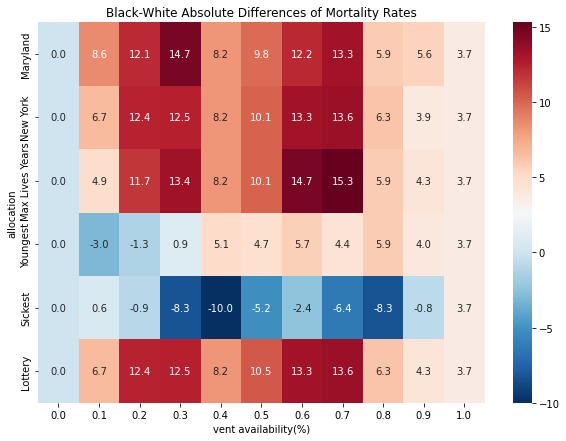

In [78]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(diff_b_w_ab, annot=True, fmt='.1f', cmap='RdBu_r')
plt.title('Black-White Absolute Differences of Mortality Rates')
plt.savefig("figure/race/heat_mortality_diff_b_w_ab.png")

In [79]:
display(diff_b_w_ab.mean(axis=1).round(1).to_frame(name='AVG'))
display(diff_b_w_ab.mean(axis=0).round(1).to_frame(name='AVG'))

,AVG
allocation,
Maryland,8.6
New York,8.2
Max Lives Years,8.4
Youngest,2.7
Sickest,-3.5
Lottery,8.3


,AVG
vent availability(%),
0.0,0.0
0.1,4.1
0.2,7.7
0.3,7.6
0.4,4.6
0.5,6.7
0.6,9.5
0.7,9.0
0.8,3.7


In [80]:
display(diff_b_w_ab[aval_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
display(diff_b_w_ab[aval_1_9].mean(axis=0).round(1).to_frame(name='AVG'))

,AVG
allocation,
Maryland,10.0
New York,9.7
Max Lives Years,9.8
Youngest,2.9
Sickest,-4.6
Lottery,9.8


,AVG
vent availability(%),
0.1,4.1
0.2,7.7
0.3,7.6
0.4,4.6
0.5,6.7
0.6,9.5
0.7,9.0
0.8,3.7
0.9,3.6


### Black-White (Relative Difference)

In [81]:
diff_b_w_re = df_b.subtract(df_w)
diff_b_w_re = diff_b_w_re.divide(df_w)*100
diff_b_w_re = diff_b_w_re.round(1)
diff_b_w_re

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,0.0,9.9,15.8,22.4,15.2,21.4,31.6,45.4,25.0,32.2,25.9
New York,0.0,7.6,16.3,19.4,15.2,22.1,35.5,46.9,27.2,22.4,25.9
Max Lives Years,0.0,5.6,15.2,20.5,15.2,22.1,38.9,52.8,25.0,25.3,25.9
Youngest,0.0,-3.3,-1.5,1.2,7.4,8.4,10.7,9.8,16.8,15.7,25.9
Sickest,0.0,0.6,-1.0,-9.7,-13.0,-7.5,-4.0,-13.1,-22.0,-3.0,25.9
Lottery,0.0,7.6,16.3,19.4,15.2,23.2,35.5,46.9,27.2,25.3,25.9


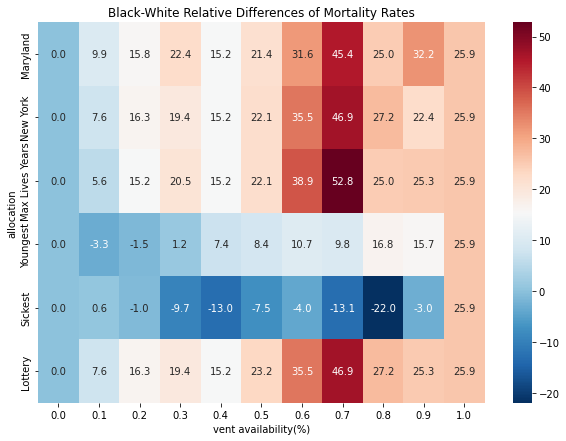

In [82]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(diff_b_w_re, annot=True, fmt='.1f', cmap='RdBu_r')
plt.title('Black-White Relative Differences of Mortality Rates')
plt.savefig("figure/race/heat_mortality_diff_b_w_re.png")

In [83]:
display(diff_b_w_re.mean(axis=1).round(1).to_frame(name='AVG'))
display(diff_b_w_re.mean(axis=0).round(1).to_frame(name='AVG'))

,AVG
allocation,
Maryland,22.3
New York,21.7
Max Lives Years,22.4
Youngest,8.3
Sickest,-4.3
Lottery,22.0


,AVG
vent availability(%),
0.0,0.0
0.1,4.7
0.2,10.2
0.3,12.2
0.4,9.2
0.5,15.0
0.6,24.7
0.7,31.4
0.8,16.5


In [84]:
display(diff_b_w_re[aval_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
display(diff_b_w_re[aval_1_9].mean(axis=0).round(1).to_frame(name='AVG'))

,AVG
allocation,
Maryland,24.3
New York,23.6
Max Lives Years,24.5
Youngest,7.2
Sickest,-8.1
Lottery,24.1


,AVG
vent availability(%),
0.1,4.7
0.2,10.2
0.3,12.2
0.4,9.2
0.5,15.0
0.6,24.7
0.7,31.4
0.8,16.5
0.9,19.7


### Avg(Hispanic-White & Black-White) (Absolute)

In [85]:
diff_h_w = df_h.subtract(df_w)
diff_b_w = df_b.subtract(df_w)
diff_h_b_w_avg_ab = diff_h_w.add(diff_b_w).divide(2)
diff_h_b_w_avg_ab = diff_h_b_w_avg_ab.round(1)
diff_h_b_w_avg_ab

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,0.0,6.8,8.3,10.2,9.2,9.0,9.1,11.0,6.0,5.2,3.4
New York,0.0,4.2,8.7,10.3,9.3,9.5,10.9,11.3,6.6,4.4,3.4
Max Lives Years,0.0,4.9,7.8,10.0,9.3,9.4,11.2,12.0,6.0,4.8,3.4
Youngest,0.0,-1.8,-2.8,-1.5,-0.4,-0.5,-1.0,-1.6,0.7,1.2,3.4
Sickest,0.0,0.1,-2.2,-7.1,-8.0,-5.6,-4.6,-4.9,-4.7,-0.8,3.4
Lottery,0.0,4.2,8.7,10.3,9.3,9.9,10.9,11.3,6.6,4.8,3.4


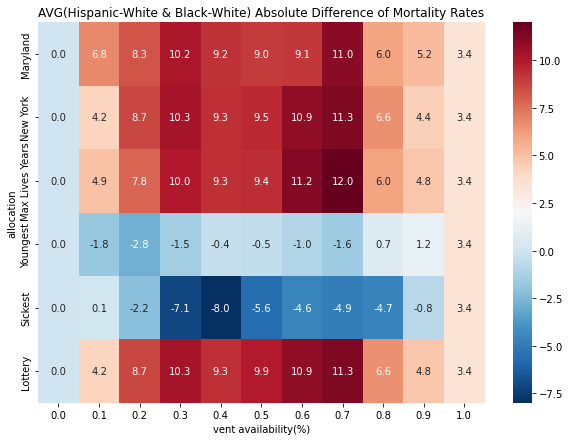

In [86]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(diff_h_b_w_avg_ab, annot=True, fmt='.1f', cmap='RdBu_r')
plt.title('AVG(Hispanic-White & Black-White) Absolute Difference of Mortality Rates')
plt.savefig("figure/race/heat_mortality_diff_avg_ab.png")

In [87]:
display(diff_h_b_w_avg_ab.mean(axis=1).round(1).to_frame(name='AVG'))
display(diff_h_b_w_avg_ab.mean(axis=0).round(1).to_frame(name='AVG'))

,AVG
allocation,
Maryland,7.1
New York,7.1
Max Lives Years,7.2
Youngest,-0.4
Sickest,-3.1
Lottery,7.2


,AVG
vent availability(%),
0.0,0.0
0.1,3.1
0.2,4.8
0.3,5.4
0.4,4.8
0.5,5.3
0.6,6.1
0.7,6.5
0.8,3.5


In [88]:
display(diff_h_b_w_avg_ab[aval_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
display(diff_h_b_w_avg_ab[aval_1_9].mean(axis=0).round(1).to_frame(name='AVG'))

,AVG
allocation,
Maryland,8.3
New York,8.4
Max Lives Years,8.4
Youngest,-0.9
Sickest,-4.2
Lottery,8.4


,AVG
vent availability(%),
0.1,3.1
0.2,4.8
0.3,5.4
0.4,4.8
0.5,5.3
0.6,6.1
0.7,6.5
0.8,3.5
0.9,3.3


### Avg(Hispanic-White & Black-White) (Relative)

In [89]:
diff_b_w_re = df_b.subtract(df_w)
diff_b_w_re = diff_b_w_re.divide(df_w)*100
diff_b_w_re = diff_b_w_re.round(1)
diff_b_w_re

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,0.0,9.9,15.8,22.4,15.2,21.4,31.6,45.4,25.0,32.2,25.9
New York,0.0,7.6,16.3,19.4,15.2,22.1,35.5,46.9,27.2,22.4,25.9
Max Lives Years,0.0,5.6,15.2,20.5,15.2,22.1,38.9,52.8,25.0,25.3,25.9
Youngest,0.0,-3.3,-1.5,1.2,7.4,8.4,10.7,9.8,16.8,15.7,25.9
Sickest,0.0,0.6,-1.0,-9.7,-13.0,-7.5,-4.0,-13.1,-22.0,-3.0,25.9
Lottery,0.0,7.6,16.3,19.4,15.2,23.2,35.5,46.9,27.2,25.3,25.9


In [90]:
diff_h_w_re = df_h.subtract(df_w)
diff_h_w_re = diff_h_w_re.divide(df_w)*100
diff_h_w_re = diff_h_w_re.round(1)

diff_b_w_re = df_b.subtract(df_w)
diff_b_w_re = diff_b_w_re.divide(df_w)*100
diff_b_w_re = diff_b_w_re.round(1)

diff_h_b_w_avg_re = diff_h_w_re.add(diff_b_w_re).divide(2)
diff_h_b_w_avg_re = diff_h_b_w_avg_re.round(1)
diff_h_b_w_avg_re

vent availability(%),0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
allocation,,,,,,,,,,,
Maryland,0.0,7.8,10.9,15.6,17.1,19.5,23.7,37.6,25.6,29.6,23.4
New York,0.0,4.8,11.4,16.0,17.3,20.8,29.1,39.0,28.4,25.3,23.4
Max Lives Years,0.0,5.6,10.0,15.2,17.3,20.6,29.6,41.6,25.6,28.2,23.4
Youngest,0.0,-1.9,-3.3,-2.0,-0.6,-0.9,-2.0,-3.6,2.0,4.7,23.4
Sickest,0.0,0.1,-2.5,-8.4,-10.3,-8.2,-7.8,-10.1,-12.4,-3.2,23.4
Lottery,0.0,4.8,11.4,16.0,17.3,21.9,29.1,39.0,28.4,28.2,23.4


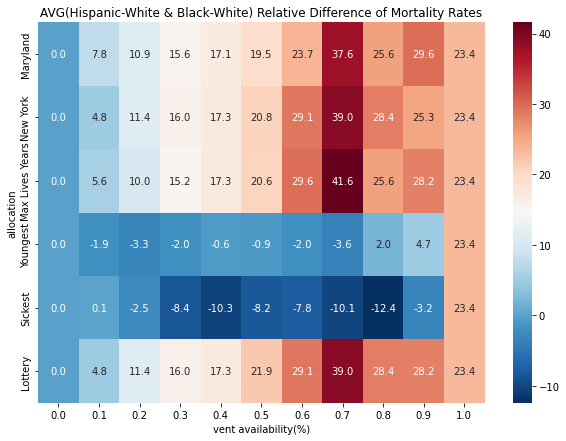

In [91]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(diff_h_b_w_avg_re, annot=True, fmt='.1f', cmap='RdBu_r')
plt.title('AVG(Hispanic-White & Black-White) Relative Difference of Mortality Rates')
plt.savefig("figure/race/heat_mortality_diff_avg_re.png")

In [92]:
display(diff_h_b_w_avg_re.mean(axis=1).round(1).to_frame(name='AVG'))
display(diff_h_b_w_avg_re.mean(axis=0).round(1).to_frame(name='AVG'))

,AVG
allocation,
Maryland,19.2
New York,19.6
Max Lives Years,19.7
Youngest,1.4
Sickest,-3.6
Lottery,20.0


,AVG
vent availability(%),
0.0,0.0
0.1,3.5
0.2,6.3
0.3,8.7
0.4,9.7
0.5,12.3
0.6,17.0
0.7,23.9
0.8,16.3


In [93]:
display(diff_h_b_w_avg_re[aval_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
display(diff_h_b_w_avg_re[aval_1_9].mean(axis=0).round(1).to_frame(name='AVG'))

,AVG
allocation,
Maryland,20.8
New York,21.3
Max Lives Years,21.5
Youngest,-0.8
Sickest,-7.0
Lottery,21.8


,AVG
vent availability(%),
0.1,3.5
0.2,6.3
0.3,8.7
0.4,9.7
0.5,12.3
0.6,17.0
0.7,23.9
0.8,16.3
0.9,18.8
